Dropout statistics data analyis
=====
This notebook summarizes the efforts made in the analysis of statistical dropout data for the standard 4130cu. in. array with Bolt LLXT guns. Other arrays or dropout rules may easily be analyzed by saving this Jupyter Notebook with a new name and feed in the raw statistics (dan) files for the relavant source. Dropout rules are specified in this notebook under the Heading called Dropout Rule.

## Motivation
Dropout specs and modeling has been a topic for discussion for years:
The tolerance specs are sharp, resulting in a red or green box in a dropout matrix, but the matrix is based on a set of assumptions that are quite inaccurate.

<li>Source modeling code and calibration: old vs new matters</li>

<li>Temperature sensitivity</li>

<li>We are assuming a static and 100% correctly deployed source.</li>

<li>Dropouts are done on vertical farfields, even if relevant farfields are mostly non-vertical</li>

<li>Origin of specs (operational more than geophysical, “nice round numbers”).</li>

<li>Etc.</li>

Reshoots due to dropouts are costly. A revision is in line with a streamlining/cost-cutting philosophy
There is no guarantee that a reshoot results in improved data quality
Current practice of bespoke dropout matrix per project is error prone and resource demanding. And triggers discussion if new modeling should be used to allow for more dropped guns.

Shot-to-shot designature: Some possibility to correct for a range of bad shots.

Include perl script

In [1]:
parentdir = "release_280" #Convention: Nucleus version. Used for dan file input reading
subdir_T = "batch_3260"
subdir_H = "batch_3265" #Convention: Source configuration. Used for dan file input reading.
sourceconf_T = "3260"
sourceconf_H = "3265" #Used for defining input dan file names and number of lines to skip. And gun number mapping
#subdir_T = "batch_4130"
#subdir_H = "batch_4135" #Convention: Source configuration. Used for dan file input reading.
#subdir_T = "batch_4130_alt"
#subdir_H = "batch_4135_alt"
#sourceconf_T = "4130"
#sourceconf_H = "4135"
mastermatrix = sourceconf_T + '_' + sourceconf_H # for plot labeling
guntype_T = "T"
guntype_H = "H" #Used to define input dan file name
nucver = "280" #Used for number of lines to skip in dan file
kernel = "k2" #Only used for plot titles and filenames

substitution_dir_T = "3260T_substitution"
substitution_dir_H = "3265H_substitution"
#substitution_dir_T = "4130T_substitution"
#substitution_dir_H = "4135H_substitution"


# Importing modules for plotting

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

## Setting some parameters for reading the input


Below, the header of two dan-files (broadband and conventional/cross-correlation) are listed to confirm the modeling parameters used in Nucleus. First specify the path to the dan files for the dataset to analyze:

In [3]:
#path = "./release_280/batch_4135/"
path_T = "./" + parentdir + "/" + subdir_T  + "/" 
path_H = "./" + parentdir + "/" + subdir_H  + "/" 
paths = [path_T, path_H]

In [4]:
print(paths)

['./release_280/batch_3260/', './release_280/batch_3265/']


In [5]:
substitution_path_T = "./" + parentdir + "/" + subdir_T  + "/" + substitution_dir_T + "/"
substitution_path_H = "./" + parentdir + "/" + subdir_H  + "/" + substitution_dir_H + "/"
substitution_paths = [substitution_path_T, substitution_path_H]

In [6]:
print(substitution_paths)

['./release_280/batch_3260/3260T_substitution/', './release_280/batch_3265/3265H_substitution/']


Setting the numbers of lines to skip. This is for the 4130 and the 3260 array.

In [7]:
if nucver == "280":
    extraline = 1
elif nucver == "271":
    extraline = 0
    
if sourceconf_T == "4130" or sourceconf_H == "4135":
    #bb statistics
    onegunskip = 43 + extraline
    twogunskip = 74 + extraline
    spareskip = 539 + extraline
    spareskip_subst = 74 + extraline
    eof = 557 + extraline
    eof_subst = 92 + extraline
    #conventional statistics
    onegunskipcc = 55 + extraline
    twogunskipcc = 86 + extraline
    spareskipcc = 551 + extraline
    spareskipcc_subst = 86 + extraline
    eofcc = 569 + extraline
    eofcc_subst = 104 + extraline
elif sourceconf_T == "3260" or sourceconf_H == "3265":
    #bb statistics
    onegunskip = 43 + extraline
    twogunskip = 65 + extraline
    spareskip = 296 + extraline
    spareskip_subst = 65 + extraline
    eof = 309 + extraline
    eof_subst = 78 + extraline
    #conventional statistics
    onegunskipcc = 55 + extraline
    twogunskipcc = 77 + extraline
    spareskipcc = 308 + extraline
    spareskipcc_subst = 77 + extraline
    eofcc = 321 + extraline
    eofcc_subst = 90 + extraline
    

arrayvol_T = sourceconf_T + guntype_T 
arrayvol_H = sourceconf_H + guntype_H 
arraydepth = [4, 5, 6, 7, 8, 9]
subsep = [8, 10]
temp = [5, 10, 15, 20, 25]
prefix = ['bb', 'cc']

Setting substitution scenario lists:

In [8]:
if sourceconf_T == "4130" or sourceconf_H == "4135":
    substscenario = ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17']
elif sourceconf_T == "3260" or sourceconf_H == "3265":
    substscenario = ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

Setting file name

In [9]:
filenames_T = []

for a in arraydepth:
	for s in subsep:
		for t in temp:
			if s < 10: 
				filenames_T.append(arrayvol_T + '__0' + str(a) + '0_2000_0' + str(s) + '0_' + str(t) + '.dan')
			else:
				filenames_T.append(arrayvol_T + '__0' + str(a) + '0_2000_' + str(s) + '0_' + str(t) + '.dan')

In [10]:
filenames_H = []

for a in arraydepth:
	for s in subsep:
		for t in temp:
			if s < 10: 
				filenames_H.append(arrayvol_H + '__0' + str(a) + '0_2000_0' + str(s) + '0_' + str(t) + '.dan')
			else:
				filenames_H.append(arrayvol_H + '__0' + str(a) + '0_2000_' + str(s) + '0_' + str(t) + '.dan')

Just checking the file names:

In [11]:
count = 0
for filename in filenames_H:
    if count < 10:
        print(filename)
    count += 1
print(len(filenames_H))

3265H__040_2000_080_5.dan
3265H__040_2000_080_10.dan
3265H__040_2000_080_15.dan
3265H__040_2000_080_20.dan
3265H__040_2000_080_25.dan
3265H__040_2000_100_5.dan
3265H__040_2000_100_10.dan
3265H__040_2000_100_15.dan
3265H__040_2000_100_20.dan
3265H__040_2000_100_25.dan
60


Substitution file names:

In [12]:
filenames_subst_T = []

for a in arraydepth:
    for s in subsep:
        for subst in substscenario:
            for t in temp:
                if s < 10:
                    filenames_subst_T.append(arrayvol_T + '__0' + str(a) + '0_0' + str(s) + '0_' + subst + "_" + str(t) + '.dan')
                else:
                    filenames_subst_T.append(arrayvol_T + '__0' + str(a) + '0_' + str(s) + '0_' + subst + "_" + str(t) + '.dan')

In [13]:
filenames_subst_H = []

for a in arraydepth:
    for s in subsep:
        for subst in substscenario:
            for t in temp:
                if s < 10:
                    filenames_subst_H.append(arrayvol_H + '__0' + str(a) + '0_0' + str(s) + '0_' + subst + "_" + str(t) + '.dan')
                else:
                    filenames_subst_H.append(arrayvol_H + '__0' + str(a) + '0_' + str(s) + '0_' + subst + "_" + str(t) + '.dan')

In [14]:
count = 0
for filename in filenames_subst_T:
    if count < 10:
        print(filename)
    count += 1
print(len(filenames_subst_T))

3260T__040_080_00_5.dan
3260T__040_080_00_10.dan
3260T__040_080_00_15.dan
3260T__040_080_00_20.dan
3260T__040_080_00_25.dan
3260T__040_080_01_5.dan
3260T__040_080_01_10.dan
3260T__040_080_01_15.dan
3260T__040_080_01_20.dan
3260T__040_080_01_25.dan
780


## Modeling Parameters
This report analyse statistical values of the following dropout scenarios:
<li>Temperatures: 5, 10, 15, 20, 25</li>
<li>Depths 4-9m; 1m increment</li>
<li>Subarray separation: 8 and 10m</li>
<li>Bolt and GII guns</li>
<li>Broadband (refl coeff zero) and conventional (refl coeff -1)</li>
Total: 123 360 combinations
<li>60 source/temperature combinations</li>
<li>2 modelings per source (broadband and conv)</li>
<li>2 gun types</li>
<li>All single and two gun dropouts with spare gun substitution</li>
<li>514 dropout combinations per source (nominal source always used as reference)</li>

The datasets are analyzed separately for Gun type to detect systematic differences.


Defining the column names:

In [15]:
columns_one_gun_bb_raw = ['droparray1', 'dropgun1', 'gunvolume1', 'AvgdB', 'MaxdB', 'MaxPhase']
columns_two_gun_bb_raw = ['droparray1', 'dropgun1', 'droparray2', 'dropgun2', 'gunvolume1', 'gunvolume2', 'AvgdB', 'MaxdB', 'MaxPhase']
columns_spare_gun_bb_raw = ['droparray1', 'dropgun1', 'droparray2', 'dropgun2', 'gunvolume1', 'gunvolume2', 'AvgdB', 'MaxdB', 'MaxPhase']	
columns_one_gun_cc_raw = ['droparray1', 'dropgun1', 'gunvolume1', 'Peak', 'Peakch','PtoB','PtoBch', 'x-corr', 'AvgdB', 'MaxdB']
columns_two_gun_cc_raw = ['droparray1', 'dropgun1', 'droparray2', 'dropgun2', 'gunvolume1', 'gunvolume2', 'Peak', 'Peakch', 'PtoB', 'PtoBch', 'x-corr', 'AvgdB', 'MaxdB']
columns_spare_gun_cc_raw = ['droparray1', 'dropgun1', 'droparray2', 'dropgun2', 'gunvolume1', 'gunvolume2', 'Peak', 'Peakch', 'PtoB', 'PtoBch', 'x-corr', 'AvgdB', 'MaxdB']

Statistical data defined as panda dataframes:

In [16]:
stat_one_gun_bb_raw = pd.DataFrame()
stat_two_gun_bb_raw = pd.DataFrame()
stat_spare_gun_bb_raw = pd.DataFrame()
stat_one_gun_cc_raw = pd.DataFrame()
stat_two_gun_cc_raw = pd.DataFrame()
stat_spare_gun_cc_raw = pd.DataFrame()

for substitution data:

In [17]:
stat_one_gun_after_subst_bb_raw = pd.DataFrame()
stat_spare_gun_after_subst_bb_raw = pd.DataFrame()
stat_one_gun_after_subst_cc_raw = pd.DataFrame()
stat_spare_gun_after_subst_cc_raw = pd.DataFrame()

Reading data from files into dataframes:

In [18]:
for path in paths:
    if ("3260" in path) or ("4130" in path):
        filenames = filenames_T
    if ("3265" in path) or ("4135" in path):
        filenames = filenames_H
    for filename in filenames:
        temp_stat_one_gun_bb_raw = pd.read_csv(path + 'bb_' + filename, names=columns_one_gun_bb_raw, skiprows=onegunskip, delim_whitespace=True, nrows=twogunskip-onegunskip)
        temp_stat_one_gun_bb_raw['filename'] = filename
        temp_stat_one_gun_bb_raw['SourceVolume'] = int(filename[:4])
        temp_stat_one_gun_bb_raw['GunType'] = (filename[4:5])        
        temp_stat_one_gun_bb_raw['Depth'] = int(filename[7:10])
        temp_stat_one_gun_bb_raw['Subsep'] = int(filename[16:19])
        temp_stat_one_gun_bb_raw['Temperature'] = int(filename[20:22].replace('.',''))
        stat_one_gun_bb_raw = stat_one_gun_bb_raw.append(temp_stat_one_gun_bb_raw)
        temp_stat_one_gun_bb_raw = []
    
        temp_stat_two_gun_bb_raw = pd.read_csv(path + 'bb_' + filename, names=columns_two_gun_bb_raw, skiprows=twogunskip, delim_whitespace=True, nrows=spareskip-twogunskip)
        temp_stat_two_gun_bb_raw['filename'] = filename
        temp_stat_two_gun_bb_raw['SourceVolume'] = int(filename[:4])
        temp_stat_two_gun_bb_raw['GunType'] = (filename[4:5])        
        temp_stat_two_gun_bb_raw['Depth'] = int(filename[7:10])
        temp_stat_two_gun_bb_raw['Subsep'] = int(filename[16:19])
        temp_stat_two_gun_bb_raw['Temperature'] = int(filename[20:22].replace('.',''))
        stat_two_gun_bb_raw = stat_two_gun_bb_raw.append(temp_stat_two_gun_bb_raw)
        temp_stat_two_gun_bb_raw = []
    
        temp_stat_spare_gun_bb_raw = pd.read_csv(path + 'bb_' + filename, names=columns_spare_gun_bb_raw, skiprows=spareskip, delim_whitespace=True, nrows=eof-spareskip)
        temp_stat_spare_gun_bb_raw['filename'] = filename
        temp_stat_spare_gun_bb_raw['SourceVolume'] = int(filename[:4])
        temp_stat_spare_gun_bb_raw['GunType'] = (filename[4:5])        
        temp_stat_spare_gun_bb_raw['Depth'] = int(filename[7:10])
        temp_stat_spare_gun_bb_raw['Subsep'] = int(filename[16:19])
        temp_stat_spare_gun_bb_raw['Temperature'] = int(filename[20:22].replace('.',''))
        stat_spare_gun_bb_raw = stat_spare_gun_bb_raw.append(temp_stat_spare_gun_bb_raw)
        temp_stat_spare_gun_bb_raw = []
    
        temp_stat_one_gun_cc_raw = pd.read_csv(path + 'cc_' + filename, names=columns_one_gun_cc_raw, skiprows=onegunskipcc, delim_whitespace=True, nrows=twogunskipcc-onegunskipcc)
        temp_stat_one_gun_cc_raw['filename'] = filename
        temp_stat_one_gun_cc_raw['SourceVolume'] = int(filename[:4])
        temp_stat_one_gun_cc_raw['GunType'] = (filename[4:5])        
        temp_stat_one_gun_cc_raw['Depth'] = int(filename[7:10])
        temp_stat_one_gun_cc_raw['Subsep'] = int(filename[16:19])
        temp_stat_one_gun_cc_raw['Temperature'] = int(filename[20:22].replace('.',''))
        stat_one_gun_cc_raw = stat_one_gun_cc_raw.append(temp_stat_one_gun_cc_raw)
        temp_stat_one_gun_cc_raw = []
    
        temp_stat_two_gun_cc_raw = pd.read_csv(path + 'cc_' + filename, names=columns_two_gun_cc_raw, skiprows=twogunskipcc, delim_whitespace=True, nrows=spareskipcc-twogunskipcc)
        temp_stat_two_gun_cc_raw['filename'] = filename
        temp_stat_two_gun_cc_raw['SourceVolume'] = int(filename[:4])
        temp_stat_two_gun_cc_raw['GunType'] = (filename[4:5])        
        temp_stat_two_gun_cc_raw['Depth'] = int(filename[7:10])
        temp_stat_two_gun_cc_raw['Subsep'] = int(filename[16:19])
        temp_stat_two_gun_cc_raw['Temperature'] = int(filename[20:22].replace('.',''))
        stat_two_gun_cc_raw = stat_two_gun_cc_raw.append(temp_stat_two_gun_cc_raw)
        temp_stat_two_gun_cc_raw = []
    
        temp_stat_spare_gun_cc_raw = pd.read_csv(path + 'cc_' + filename, names=columns_spare_gun_cc_raw, skiprows=spareskipcc, delim_whitespace=True, nrows=eofcc-spareskipcc)
        temp_stat_spare_gun_cc_raw['filename'] = filename
        temp_stat_spare_gun_cc_raw['SourceVolume'] = int(filename[:4])
        temp_stat_spare_gun_cc_raw['GunType'] = (filename[4:5])        
        temp_stat_spare_gun_cc_raw['Depth'] = int(filename[7:10])
        temp_stat_spare_gun_cc_raw['Subsep'] = int(filename[16:19])
        temp_stat_spare_gun_cc_raw['Temperature'] = int(filename[20:22].replace('.',''))
        stat_spare_gun_cc_raw = stat_spare_gun_cc_raw.append(temp_stat_spare_gun_cc_raw)
        temp_stat_spare_gun_cc_raw = []

In [19]:
stat_one_gun_bb_raw.reset_index(inplace=True)
stat_two_gun_bb_raw.reset_index(inplace=True)
stat_spare_gun_bb_raw.reset_index(inplace=True)
stat_one_gun_cc_raw.reset_index(inplace=True)
stat_two_gun_cc_raw.reset_index(inplace=True)
stat_spare_gun_cc_raw.reset_index(inplace=True)

In [20]:
for path in substitution_paths:
    if ("3260" in path) or ("4130" in path):
        filenames = filenames_subst_T
    if ("3265" in path) or ("4135" in path):
        filenames = filenames_subst_H
    for filename in filenames:
        temp_stat_one_gun_after_subst_bb_raw = pd.read_csv(path + 'bb_' + filename, names=columns_one_gun_bb_raw, skiprows=onegunskip, delim_whitespace=True, nrows=spareskip_subst-onegunskip)
        temp_stat_one_gun_after_subst_bb_raw['filename'] = filename
        temp_stat_one_gun_after_subst_bb_raw['SourceVolume'] = int(filename[:4])
        temp_stat_one_gun_after_subst_bb_raw['GunType'] = (filename[4:5])        
        temp_stat_one_gun_after_subst_bb_raw['Depth'] = int(filename[7:10])
        temp_stat_one_gun_after_subst_bb_raw['Subsep'] = int(filename[11:14])
        temp_stat_one_gun_after_subst_bb_raw['Substscenario'] = filename[15:17]
        temp_stat_one_gun_after_subst_bb_raw['Temperature'] = int(filename[18:20].replace('.',''))
        stat_one_gun_after_subst_bb_raw = stat_one_gun_after_subst_bb_raw.append(temp_stat_one_gun_after_subst_bb_raw)
        temp_stat_one_after_subst_gun_after_subst_bb_raw = []
        
        temp_stat_spare_gun_after_subst_bb_raw = pd.read_csv(path + 'bb_' + filename, names=columns_spare_gun_bb_raw, skiprows=spareskip_subst, delim_whitespace=True, nrows=eof_subst-spareskip_subst)
        temp_stat_spare_gun_after_subst_bb_raw['filename'] = filename
        temp_stat_spare_gun_after_subst_bb_raw['SourceVolume'] = int(filename[:4])
        temp_stat_spare_gun_after_subst_bb_raw['GunType'] = (filename[4:5])        
        temp_stat_spare_gun_after_subst_bb_raw['Depth'] = int(filename[7:10])
        temp_stat_spare_gun_after_subst_bb_raw['Subsep'] = int(filename[11:14])
        temp_stat_spare_gun_after_subst_bb_raw['Substscenario'] = filename[15:17]
        temp_stat_spare_gun_after_subst_bb_raw['Temperature'] = int(filename[18:20].replace('.',''))
        stat_spare_gun_after_subst_bb_raw = stat_spare_gun_after_subst_bb_raw.append(temp_stat_spare_gun_after_subst_bb_raw)
        temp_stat_spare_gun_bb_raw = []
        
        temp_stat_one_gun_after_subst_cc_raw = pd.read_csv(path + 'cc_' + filename, names=columns_one_gun_cc_raw, skiprows=onegunskipcc, delim_whitespace=True, nrows=spareskipcc_subst-onegunskipcc)
        temp_stat_one_gun_after_subst_cc_raw['filename'] = filename
        temp_stat_one_gun_after_subst_cc_raw['SourceVolume'] = int(filename[:4])
        temp_stat_one_gun_after_subst_cc_raw['GunType'] = (filename[4:5])        
        temp_stat_one_gun_after_subst_cc_raw['Depth'] = int(filename[7:10])
        temp_stat_one_gun_after_subst_cc_raw['Subsep'] = int(filename[11:14])
        temp_stat_one_gun_after_subst_cc_raw['Substscenario'] = filename[15:17]
        temp_stat_one_gun_after_subst_cc_raw['Temperature'] = int(filename[18:20].replace('.',''))
        stat_one_gun_after_subst_cc_raw = stat_one_gun_after_subst_cc_raw.append(temp_stat_one_gun_after_subst_cc_raw)
        temp_stat_one_gun_after_subst_cc_raw = []
        
        temp_stat_spare_gun_after_subst_cc_raw = pd.read_csv(path + 'cc_' + filename, names=columns_spare_gun_cc_raw, skiprows=spareskipcc_subst, delim_whitespace=True, nrows=eofcc_subst-spareskipcc_subst)
        temp_stat_spare_gun_after_subst_cc_raw['filename'] = filename
        temp_stat_spare_gun_after_subst_cc_raw['SourceVolume'] = int(filename[:4])
        temp_stat_spare_gun_after_subst_cc_raw['GunType'] = (filename[4:5])        
        temp_stat_spare_gun_after_subst_cc_raw['Depth'] = int(filename[7:10])
        temp_stat_spare_gun_after_subst_cc_raw['Subsep'] = int(filename[11:14])
        temp_stat_spare_gun_after_subst_cc_raw['Substscenario'] = filename[15:17]
        temp_stat_spare_gun_after_subst_cc_raw['Temperature'] = int(filename[18:20].replace('.',''))
        stat_spare_gun_after_subst_cc_raw = stat_spare_gun_after_subst_cc_raw.append(temp_stat_spare_gun_after_subst_cc_raw)
        temp_stat_spare_gun_after_subst_cc_raw = []

In [21]:
stat_one_gun_after_subst_bb_raw.reset_index(inplace=True)
stat_spare_gun_after_subst_bb_raw.reset_index(inplace=True)
stat_one_gun_after_subst_cc_raw.reset_index(inplace=True)
stat_spare_gun_after_subst_cc_raw.reset_index(inplace=True)

In [22]:
stat_spare_gun_after_subst_bb_raw

,index,droparray1,dropgun1,droparray2,dropgun2,gunvolume1,gunvolume2,AvgdB,MaxdB,MaxPhase,filename,SourceVolume,GunType,Depth,Subsep,Substscenario,Temperature
0,0,1,4,1,-3,150,150,0.00,0.0,0.0,3260T__040_080_00_5.dan,3260,T,40,80,00,5
1,1,1,7,1,-3,150,150,0.08,0.9,7.6,3260T__040_080_00_5.dan,3260,T,40,80,00,5
2,2,1,8,1,-3,150,150,0.09,0.9,7.5,3260T__040_080_00_5.dan,3260,T,40,80,00,5
3,3,1,13,1,-3,150,150,0.15,2.4,18.2,3260T__040_080_00_5.dan,3260,T,40,80,00,5
4,4,1,14,1,-3,150,150,0.16,2.5,18.7,3260T__040_080_00_5.dan,3260,T,40,80,00,5
5,5,2,1,1,-3,150,150,0.18,2.2,19.3,3260T__040_080_00_5.dan,3260,T,40,80,00,5
6,6,2,2,1,-3,150,150,0.17,2.2,18.7,3260T__040_080_00_5.dan,3260,T,40,80,00,5
7,7,1,5,2,-12,250,250,0.15,2.0,13.9,3260T__040_080_00_5.dan,3260,T,40,80,00,5
8,8,1,6,2,-12,250,250,0.16,2.0,13.5,3260T__040_080_00_5.dan,3260,T,40,80,00,5
9,9,1,9,2,-12,250,250,0.16,2.8,17.9,3260T__040_080_00_5.dan,3260,T,40,80,00,5


The follwing is a lambda function that converts to string and adds zeros to a total length of 2 characters to the input x (which could be an int). Is later used to convert all gun numbers from int to string. (3 to "03", for example)

Adding all the string representations for gun numbering in a dedicated set of columns. Is later used to make array_gun_number index with a logical order. 

In [23]:
stat_one_gun_cc_raw['Bubble'] = stat_one_gun_cc_raw.apply(lambda row: row.Peak / row.PtoB, axis=1)
stat_two_gun_cc_raw['Bubble'] = stat_two_gun_cc_raw.apply(lambda row: row.Peak / row.PtoB, axis=1)
stat_spare_gun_cc_raw['Bubble'] = stat_spare_gun_cc_raw.apply(lambda row: row.Peak / row.PtoB, axis=1)

In [24]:
stat_one_gun_after_subst_cc_raw['Bubble'] = stat_one_gun_after_subst_cc_raw.apply(lambda row: row.Peak / row.PtoB, axis=1)
stat_spare_gun_after_subst_cc_raw['Bubble'] = stat_spare_gun_after_subst_cc_raw.apply(lambda row: row.Peak / row.PtoB, axis=1)

Printing some statistics to check that dataframes are ok (Remove hash for what you want to print)

In [25]:
#print('stat_one_gun_bb_raw: ')
#print(stat_one_gun_bb_raw.head())
#print(stat_one_gun_bb_raw.head())
#print(stat_one_gun_bb_raw.tail())
#print(stat_one_gun_cc_raw)
#print(stat_two_gun_bb_raw.info())
#print('stat_spare_gun')

#print(stat_one_gun_cc_raw.head())
print(stat_two_gun_cc_raw.head())
#print('stat_two_gun_cc_raw: ')
#print(stat_two_gun_cc_raw.head())
#print(stat_two_gun_cc_raw.info())
# print('stat_spare_gun_cc_raw')
#print(stat_spare_gun_cc_raw.tail())
# print(stat_spare_gun_cc_raw.info())
#print(len(stat_one_gun_bb_raw), len(stat_two_gun_bb_raw), len(stat_spare_gun_bb_raw))
#print(len(stat_one_gun_cc_raw), len(stat_two_gun_cc_raw), len(stat_spare_gun_cc_raw))

   index  droparray1  dropgun1  droparray2  dropgun2  gunvolume1  gunvolume2  \
0      0           1         1           1         2          90          90   
1      1           1         1           1         3          90         150   
2      2           1         1           1         5          90         250   
3      3           1         1           1         6          90         250   
4      4           1         1           1         7          90         150   

   Peak  Peakch  PtoB    ...     x-corr  AvgdB  MaxdB  \
0  48.0    -8.5  34.6    ...     0.9998   0.66    0.8   
1  48.2    -8.1  30.4    ...     0.9994   0.70    1.6   
2  48.4    -7.8  35.6    ...     0.9983   0.79    1.9   
3  48.3    -7.9  35.6    ...     0.9982   0.78    2.0   
4  48.6    -7.2  35.7    ...     0.9994   0.60    1.6   

                    filename SourceVolume  GunType Depth  Subsep  Temperature  \
0  3260T__040_2000_080_5.dan         3260        T    40      80            5   
1  3260T__040_

Next step is to copy dataframes to identical copy with "all" postfix. Then later, the mastermatrix filter will be applied to the original dataframes. The "all" dataframes will contain the unfiltered data material.

In [26]:
stat_one_gun_raw = stat_one_gun_bb_raw.join(stat_one_gun_cc_raw, how='inner', rsuffix = "-cc").drop(columns=['index-cc', 'filename-cc', 'SourceVolume-cc', 'GunType-cc', 'Depth-cc', 'Subsep-cc', 'Temperature-cc', 'droparray1-cc', 'dropgun1-cc', 'gunvolume1-cc'])
stat_two_gun_raw = stat_two_gun_bb_raw.join(stat_two_gun_cc_raw, how='inner', rsuffix = "-cc").drop(columns=['index-cc', 'filename-cc', 'SourceVolume-cc', 'GunType-cc', 'Depth-cc', 'Subsep-cc', 'Temperature-cc', 'droparray1-cc', 'droparray2-cc', 'dropgun1-cc', 'dropgun2-cc', 'gunvolume1-cc', 'gunvolume2-cc'])
stat_spare_gun_raw = stat_spare_gun_bb_raw.join(stat_spare_gun_cc_raw, how='inner', rsuffix = "-cc").drop(columns=['index-cc', 'filename-cc', 'SourceVolume-cc', 'GunType-cc', 'Depth-cc', 'Subsep-cc', 'Temperature-cc', 'droparray1-cc', 'droparray2-cc', 'dropgun1-cc', 'dropgun2-cc', 'gunvolume1-cc', 'gunvolume2-cc'])

In [27]:
stat_one_gun_after_subst_raw = stat_one_gun_after_subst_bb_raw.join(stat_one_gun_after_subst_cc_raw, how='inner', rsuffix = "-cc").drop(columns=['index-cc', 'filename-cc', 'SourceVolume-cc', 'GunType-cc', 'Depth-cc', 'Subsep-cc', 'Temperature-cc', 'droparray1-cc', 'dropgun1-cc', 'gunvolume1-cc', 'Substscenario-cc'])
stat_spare_gun_after_subst_raw = stat_spare_gun_after_subst_bb_raw.join(stat_spare_gun_after_subst_cc_raw, how='inner', rsuffix = "-cc").drop(columns=['index-cc', 'filename-cc', 'SourceVolume-cc', 'GunType-cc', 'Depth-cc', 'Subsep-cc', 'Temperature-cc', 'droparray1-cc', 'droparray2-cc', 'dropgun1-cc', 'dropgun2-cc', 'gunvolume1-cc', 'gunvolume2-cc', 'Substscenario-cc'])

In [28]:
#stat_two_gun_raw

In [29]:
print(len(stat_spare_gun_after_subst_raw))

20280


In [30]:
add_zero = lambda x: str(abs(int(x))).zfill(2)

In [31]:
stat_one_gun_raw['dropgun1_str'] = stat_one_gun_raw['dropgun1'].apply(add_zero)
stat_two_gun_raw['dropgun1_str'] = stat_two_gun_raw['dropgun1'].apply(add_zero)
stat_two_gun_raw['dropgun2_str'] = stat_two_gun_raw['dropgun2'].apply(add_zero)
stat_spare_gun_raw['dropgun1_str'] = stat_spare_gun_raw['dropgun1'].apply(add_zero)
stat_spare_gun_raw['dropgun2_str'] = stat_spare_gun_raw['dropgun2'].apply(add_zero)

In [32]:
stat_one_gun_after_subst_raw['dropgun1_str'] = stat_one_gun_after_subst_raw['dropgun1'].apply(add_zero)
stat_spare_gun_after_subst_raw['dropgun1_str'] = stat_spare_gun_after_subst_raw['dropgun1'].apply(add_zero)
stat_spare_gun_after_subst_raw['dropgun2_str'] = stat_spare_gun_after_subst_raw['dropgun2'].apply(add_zero)

In [33]:
stat_one_gun_raw["gun1_unique"] = stat_one_gun_raw["droparray1"].astype(str) + '.' + stat_one_gun_raw["dropgun1_str"]
stat_two_gun_raw["gun1_unique"] = stat_two_gun_raw["droparray1"].astype(str) + '.' + stat_two_gun_raw["dropgun1_str"]
stat_two_gun_raw["gun2_unique"] = stat_two_gun_raw["droparray2"].astype(str) + '.' + stat_two_gun_raw["dropgun2_str"]
stat_spare_gun_raw["gun1_unique"] = stat_spare_gun_raw["droparray1"].astype(str) + '.' + stat_spare_gun_raw["dropgun1_str"]
stat_spare_gun_raw["gun2_unique"] = stat_spare_gun_raw["droparray2"].astype(str) + '.' + stat_spare_gun_raw["dropgun2_str"]

In [34]:
stat_one_gun_after_subst_raw["gun1_unique"] = stat_one_gun_after_subst_raw["droparray1"].astype(str) + '.' + stat_one_gun_after_subst_raw["dropgun1_str"]
stat_spare_gun_after_subst_raw["gun1_unique"] = stat_spare_gun_after_subst_raw["droparray1"].astype(str) + '.' + stat_spare_gun_after_subst_raw["dropgun1_str"]
stat_spare_gun_after_subst_raw["gun2_unique"] = stat_spare_gun_after_subst_raw["droparray2"].astype(str) + '.' + stat_spare_gun_after_subst_raw["dropgun2_str"]

In [35]:
#stat_one_gun_raw['gun1_unique'] = str(stat_one_gun_raw['droparray1']) + '.' + stat_one_gun_raw['dropgun1_str']
#stat_one_gun_raw['gun1_unique'] = stat_one_gun_raw.apply(lambda row: str(row['droparray1']) + '.' + row['dropgun1_str'], axis=1)
#stat_two_gun_raw['gun1_unique'] = stat_two_gun_raw.apply(lambda row: str(row['droparray1']) + '.' + row['dropgun1_str'], axis=1)
#stat_two_gun_raw['gun2_unique'] = stat_two_gun_raw.apply(lambda row: str(row['droparray2']) + '.' + row['dropgun2_str'], axis=1)
#stat_spare_gun_raw['gun1_unique'] = stat_spare_gun_raw.apply(lambda row: str(row['droparray1']) + '.' + row['dropgun1_str'], axis=1)
#stat_spare_gun_raw['gun2_unique'] = stat_spare_gun_raw.apply(lambda row: str(row['droparray2']) + '.' + row['dropgun2_str'], axis=1)

In [36]:
#stat_one_gun_raw

In [37]:
if sourceconf_T == "4130" or sourceconf_H == "4135":
    gun_mapping = {'1.01': 1,
                   '1.02': 2, 
                   '1.03': 3, 
                   '1.04': 4, 
                   '1.05': 5, 
                   '1.07': 6, 
                   '1.09': 7, 
                   '1.10': 8,
                   '1.11': 9, 
                   '1.12': 10, 
                   '1.13': 11, 
                   '1.14': 12, 
                   '2.01': 13, 
                   '2.02': 14, 
                   '2.03': 15, 
                   '2.05': 16, 
                   '2.07': 17, 
                   '2.09': 18, 
                   '2.11': 19, 
                   '2.12': 20, 
                   '2.13': 21,
                   '2.14': 22,
                   '3.01': 23, 
                   '3.02': 24, 
                   '3.03': 25,
                   '3.04': 26,
                   '3.05': 27, 
                   '3.07': 28, 
                   '3.09': 29, 
                   '3.10': 30, 
                   '3.11': 31, 
                   '3.12': 32, 
                   '3.13': 33, 
                   '3.14': 34}
elif sourceconf_T == "3260" or sourceconf_H == "3265":
    gun_mapping = {'1.01': 1,
                   '1.02': 2, 
                   '1.03': 3, 
                   '1.04': 4, 
                   '1.05': 5,
                   '1.06': 6,
                   '1.07': 7,
                   '1.08': 8, 
                   '1.09': 9,
                   '1.11': 10, 
                   '1.13': 11, 
                   '1.14': 12, 
                   '2.01': 13, 
                   '2.02': 14, 
                   '2.03': 15, 
                   '2.05': 16, 
                   '2.07': 17, 
                   '2.08': 18, 
                   '2.09': 19,
                   '2.10': 20,
                   '2.11': 21,
                   '2.12': 22, 
                   '2.13': 23,
                   '2.14': 24}
print(gun_mapping)

{'1.01': 1, '1.02': 2, '1.03': 3, '1.04': 4, '1.05': 5, '1.06': 6, '1.07': 7, '1.08': 8, '1.09': 9, '1.11': 10, '1.13': 11, '1.14': 12, '2.01': 13, '2.02': 14, '2.03': 15, '2.05': 16, '2.07': 17, '2.08': 18, '2.09': 19, '2.10': 20, '2.11': 21, '2.12': 22, '2.13': 23, '2.14': 24}


In [38]:
stat_one_gun_raw["gun1_num"] = stat_one_gun_raw.gun1_unique.map(gun_mapping)
stat_two_gun_raw["gun1_num"] = stat_two_gun_raw.gun1_unique.map(gun_mapping)
stat_two_gun_raw["gun2_num"] = stat_two_gun_raw.gun2_unique.map(gun_mapping)
stat_spare_gun_raw["gun1_num"] = stat_spare_gun_raw.gun1_unique.map(gun_mapping)
stat_spare_gun_raw["gun2_num"] = stat_spare_gun_raw.gun2_unique.map(gun_mapping)

In [39]:
stat_one_gun_after_subst_raw["gun1_num"] = stat_one_gun_after_subst_raw.gun1_unique.map(gun_mapping)
stat_spare_gun_after_subst_raw["gun1_num"] = stat_spare_gun_after_subst_raw.gun1_unique.map(gun_mapping)
stat_spare_gun_after_subst_raw["gun2_num"] = stat_spare_gun_after_subst_raw.gun2_unique.map(gun_mapping)

In [40]:
#stat_two_gun_raw

stat_one_gun_bb_legal = stat_one_gun_bb_raw.copy(deep=True)
stat_two_gun_bb_legal = stat_two_gun_bb_raw.copy(deep=True)
stat_spare_gun_bb_legal = stat_spare_gun_bb_raw.copy(deep=True)
stat_one_gun_cc_legal = stat_one_gun_cc_raw.copy(deep=True)
stat_two_gun_cc_legal = stat_two_gun_cc_raw.copy(deep=True)
stat_spare_gun_cc_legal = stat_spare_gun_cc_raw.copy(deep=True)

print("Number of combinations for all(raw) combinations (one gun, two gun and spare)")
print(len(stat_one_gun_bb_raw), len(stat_two_gun_bb_raw), len(stat_spare_gun_bb_raw))
print(len(stat_one_gun_cc_raw), len(stat_two_gun_cc_raw), len(stat_spare_gun_cc_raw))
print("Number of combinations for legal combinations (one gun, two gun and spare)")
print(len(stat_one_gun_bb_legal), len(stat_two_gun_bb_legal), len(stat_spare_gun_bb_legal))
print(len(stat_one_gun_cc_legal), len(stat_two_gun_cc_legal), len(stat_spare_gun_cc_legal))

In [41]:
stat_one_gun_raw['Scenario'] = "One gun dropout"
stat_two_gun_raw['Scenario'] = "Two gun dropout"
stat_spare_gun_raw['Scenario'] = "Spare substitution"


In [42]:
stat_one_gun_after_subst_raw['Scenario'] = "One gun dropout after substitution"
stat_spare_gun_after_subst_raw['Scenario'] = "Spare substitution after substitution"

## Rerun from here to avoid reading in data

In [43]:
stat_one_gun = stat_one_gun_raw
stat_two_gun = stat_two_gun_raw
stat_spare_gun = stat_spare_gun_raw
stat_one_gun_after_subst = stat_one_gun_after_subst_raw
stat_spare_gun_after_subst = stat_spare_gun_after_subst_raw

## Dropout Rule
Master Matrix suggestion:
<li>Illegal dropouts are defined by operationally suitable gun combinations and not by “geophysical” specs:</li>

<li>All substitutions allowed</li>

<li>Same rule applied regardless of depth, gun type, subarray separation, temperature.</li>

<li>We probably have to live with some outliers (keep shooting in some of the red boxes). This notebook investigates the impact on a statistical level.</li>

The goal for the new dropout rule is:
<b>“No single gun dropout is a show- stopper. All failing big guns in clusters may be substituted”</b>

### Traditional matrix

Will add columns bb_Legal and cc_Legal

In [44]:
stat_one_gun["bb_Legal"] = (stat_one_gun['AvgdB'] < 0.85) & (stat_one_gun['MaxdB'] < 3) & (stat_one_gun['MaxPhase'] < 20)
stat_one_gun["cc_Legal"] = (stat_one_gun['AvgdB-cc'] < 1.2) & (stat_one_gun['MaxdB-cc'] < 3) & (stat_one_gun['x-corr'] > 0.998)
stat_two_gun["bb_Legal"] = (stat_two_gun['AvgdB'] < 0.85) & (stat_two_gun['MaxdB'] < 3) & (stat_two_gun['MaxPhase'] < 20)
stat_two_gun["cc_Legal"] = (stat_two_gun['AvgdB-cc'] < 1.2) & (stat_two_gun['MaxdB-cc'] < 3) & (stat_two_gun['x-corr'] > 0.998)
stat_spare_gun["bb_Legal"] = (stat_spare_gun['AvgdB'] < 0.85) & (stat_spare_gun['MaxdB'] < 3) & (stat_spare_gun['MaxPhase'] < 20)
stat_spare_gun["cc_Legal"] = (stat_spare_gun['AvgdB-cc'] < 1.2) & (stat_spare_gun['MaxdB-cc'] < 3) & (stat_spare_gun['x-corr'] > 0.998)

In [45]:
stat_one_gun_after_subst["bb_Legal"] = (stat_one_gun_after_subst['AvgdB'] < 0.85) & (stat_one_gun_after_subst['MaxdB'] < 3) & (stat_one_gun_after_subst['MaxPhase'] < 20)
stat_one_gun_after_subst["cc_Legal"] = (stat_one_gun_after_subst['AvgdB-cc'] < 1.2) & (stat_one_gun_after_subst['MaxdB-cc'] < 3) & (stat_one_gun_after_subst['x-corr'] > 0.998)
stat_spare_gun_after_subst["bb_Legal"] = (stat_spare_gun_after_subst['AvgdB'] < 0.85) & (stat_spare_gun_after_subst['MaxdB'] < 3) & (stat_spare_gun_after_subst['MaxPhase'] < 20)
stat_spare_gun_after_subst["cc_Legal"] = (stat_spare_gun_after_subst['AvgdB-cc'] < 1.2) & (stat_spare_gun_after_subst['MaxdB-cc'] < 3) & (stat_spare_gun_after_subst['x-corr'] > 0.998)

In [46]:
stat_one_gun_after_subst.columns

Index(['index', 'droparray1', 'dropgun1', 'gunvolume1', 'AvgdB', 'MaxdB',
       'MaxPhase', 'filename', 'SourceVolume', 'GunType', 'Depth', 'Subsep',
       'Substscenario', 'Temperature', 'Peak', 'Peakch', 'PtoB', 'PtoBch',
       'x-corr', 'AvgdB-cc', 'MaxdB-cc', 'Bubble', 'dropgun1_str',
       'gun1_unique', 'gun1_num', 'Scenario', 'bb_Legal', 'cc_Legal'],
      dtype='object')

### Master Matrix definition and filtering of dataset
Here comes the master matrix definition and filtering. For now, master matrix input is only single and dual gun statistics and first spare substitution. Second level statistics (after first subsitution) is not included in the training of the mastermatrix.

In [47]:
epsilon = 0.10 #marginality
legal_if_ratio = 0.9 #chance of occuring. Legal if more than xx are legal
avgdb_eps = 0.85 * (1+epsilon)
maxdb_eps = 3.0 * (1+epsilon)
maxph_eps = 20 * (1+epsilon)

In [48]:
print(avgdb_eps)

0.935


In [49]:
stat_one_gun["bb_eps_Legal"] = (stat_one_gun['AvgdB'] < avgdb_eps) & (stat_one_gun['MaxdB'] < maxdb_eps) & (stat_one_gun['MaxPhase'] < maxph_eps)
stat_two_gun["bb_eps_Legal"] = (stat_two_gun['AvgdB'] < avgdb_eps) & (stat_two_gun['MaxdB'] < maxdb_eps) & (stat_two_gun['MaxPhase'] < maxph_eps)
stat_spare_gun["bb_eps_Legal"] = (stat_spare_gun['AvgdB'] < avgdb_eps) & (stat_spare_gun['MaxdB'] < maxdb_eps) & (stat_spare_gun['MaxPhase'] < maxph_eps)


In [50]:
temp_one_gun = stat_one_gun[['gun1_num', 'bb_eps_Legal']]

In [51]:
MM_one_gun = temp_one_gun.groupby(['gun1_num']).mean() > legal_if_ratio

In [52]:
MM_one_gun.reset_index(inplace=True)
MM_one_gun.rename(columns={'bb_eps_Legal': 'MM_Legal'}, inplace=True)

In [53]:
temp_two_gun = stat_two_gun[['gun1_num', 'gun2_num', 'bb_eps_Legal']]

In [54]:
MM_two_gun = temp_two_gun.groupby(['gun1_num', 'gun2_num']).mean() > legal_if_ratio

In [55]:
MM_two_gun.reset_index(inplace=True)
MM_two_gun.rename(columns={'bb_eps_Legal': 'MM_Legal'}, inplace=True)

In [56]:
temp_spare_gun = stat_spare_gun[['gun1_num', 'gun2_num', 'bb_eps_Legal']]

In [57]:
MM_spare_gun = temp_spare_gun.groupby(['gun1_num', 'gun2_num']).mean() > legal_if_ratio

In [58]:
MM_spare_gun.reset_index(inplace=True)
MM_spare_gun.rename(columns={'bb_eps_Legal': 'MM_Legal'}, inplace=True)

In [59]:
#Hard coded that one bad substitution is illegal (for 3260/3265)
#MM_spare_gun.loc[MM_spare_gun['gun1_num'] == 9, ['MM_Legal']] = False

In [60]:
MM_spare_gun

,gun1_num,gun2_num,MM_Legal
0,3,4,True
1,5,22,False
2,6,22,False
3,7,4,True
4,8,4,True
5,9,22,False
6,11,4,True
7,12,4,True
8,13,4,False
9,14,4,False


In [61]:
stat_one_gun = stat_one_gun.merge(MM_one_gun, on='gun1_num')

In [62]:
stat_two_gun = stat_two_gun.merge(MM_two_gun, on=['gun1_num', 'gun2_num'])

In [63]:
stat_spare_gun = stat_spare_gun.merge(MM_spare_gun, on=['gun1_num', 'gun2_num'])

In [64]:
stat_spare_gun[stat_spare_gun['gun1_num'] == 1]

,index,droparray1,dropgun1,droparray2,dropgun2,gunvolume1,gunvolume2,AvgdB,MaxdB,MaxPhase,...,dropgun2_str,gun1_unique,gun2_unique,gun1_num,gun2_num,Scenario,bb_Legal,cc_Legal,bb_eps_Legal,MM_Legal


Here, the mastermatrix is applied to the statistics after substitution:

In [65]:
stat_one_gun_after_subst = stat_one_gun_after_subst.merge(MM_one_gun, on='gun1_num')

In [66]:
stat_spare_gun_after_subst = stat_spare_gun_after_subst.merge(MM_spare_gun, on=['gun1_num', 'gun2_num'])

## Setting substitutions illegal for statistics after substitution- Hard coding for specifically bad substututions  

In [67]:
#Hard coded to make all the 05 substition combinations illegal (3260 & 3265 arrays)
#stat_one_gun_after_subst.loc[stat_one_gun_after_subst['Substscenario'] == '05', ['MM_Legal']] = False
#stat_spare_gun_after_subst.loc[stat_spare_gun_after_subst['Substscenario'] == '05', ['MM_Legal']] = False

#Hard coded to make all the 01 and 02 substition combinations illegal (3260 & 3265 arrays)
#stat_one_gun_after_subst.loc[stat_one_gun_after_subst['Substscenario'] == '01', ['MM_Legal']] = False
#stat_spare_gun_after_subst.loc[stat_spare_gun_after_subst['Substscenario'] == '01', ['MM_Legal']] = False
#stat_one_gun_after_subst.loc[stat_one_gun_after_subst['Substscenario'] == '02', ['MM_Legal']] = False
#stat_spare_gun_after_subst.loc[stat_spare_gun_after_subst['Substscenario'] == '02', ['MM_Legal']] = False

## Plotting starts here

In [68]:
stat_spare_gun_after_subst.columns

Index(['index', 'droparray1', 'dropgun1', 'droparray2', 'dropgun2',
       'gunvolume1', 'gunvolume2', 'AvgdB', 'MaxdB', 'MaxPhase', 'filename',
       'SourceVolume', 'GunType', 'Depth', 'Subsep', 'Substscenario',
       'Temperature', 'Peak', 'Peakch', 'PtoB', 'PtoBch', 'x-corr', 'AvgdB-cc',
       'MaxdB-cc', 'Bubble', 'dropgun1_str', 'dropgun2_str', 'gun1_unique',
       'gun2_unique', 'gun1_num', 'gun2_num', 'Scenario', 'bb_Legal',
       'cc_Legal', 'MM_Legal'],
      dtype='object')

In [69]:
#sns.set_context("paper")
#sns.set_context("notebook")
sns.set_context("talk")
#sns.set_context("poster")

In [70]:
def plotmatrix_combined(figno, xsingle, ysingle, legalsingle, xdual, ydual, legaldual, xspare, yspare, legalspare, title):
    sns.set_style("white")
    plt.figure(figno, figsize=(12, 8))
    #color= ['red' if legal == 0 else 'green']
    colorsingle= ['red' if l == False else 'green' for l in legalsingle]
    colordual = ['red' if l == False else 'green' for l in legaldual]
    colorspare = ['red' if l == False else 'green' for l in legalspare]
    zipped = zip(xspare, yspare)
    xnewspare = []
    ynewspare = []
    for x, y in zipped:
        if x > y:
            xtemp = x
            x = y
            y = xtemp
        xnewspare.append(x)
        ynewspare.append(y)
    #print(list(zipped))
    #newx = [y if (x > y) else x for x in zipped]
    #newy = [x if (x > y) else y for y in zipped]
    plt.scatter(xsingle, ysingle, c=colorsingle, s=100, alpha=0.01)
    plt.scatter(xdual, ydual, c=colordual, s=100, alpha=0.01)
    plt.scatter(xnewspare, ynewspare, c=colorspare, s=100, alpha=0.01)
    plt.xlim(0, 36)
    plt.ylim(0, 36)
    plt.title(title)
    plt.xlabel("Gun 1")
    plt.ylabel("Gun 2")
    plt.gca().invert_yaxis()
    filename = add_zero(figno) + '_' + title + ".png"
    plt.savefig(filename)
    plt.show()


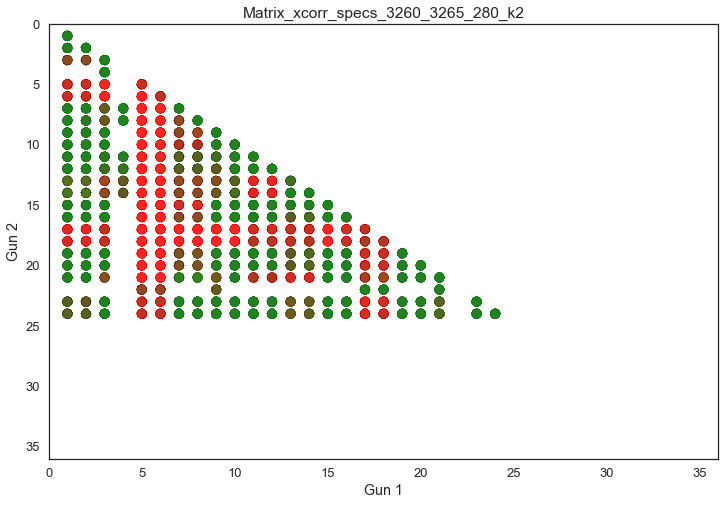

In [71]:
title1 = 'Matrix_xcorr_specs_' + mastermatrix + '_' + nucver + '_' + kernel
plotmatrix_combined(1, stat_two_gun.gun1_num, stat_two_gun.gun2_num, stat_two_gun.cc_Legal, stat_one_gun.gun1_num, stat_one_gun.gun1_num, stat_one_gun.cc_Legal, stat_spare_gun.gun1_num, stat_spare_gun.gun2_num, stat_spare_gun.cc_Legal, title1 )

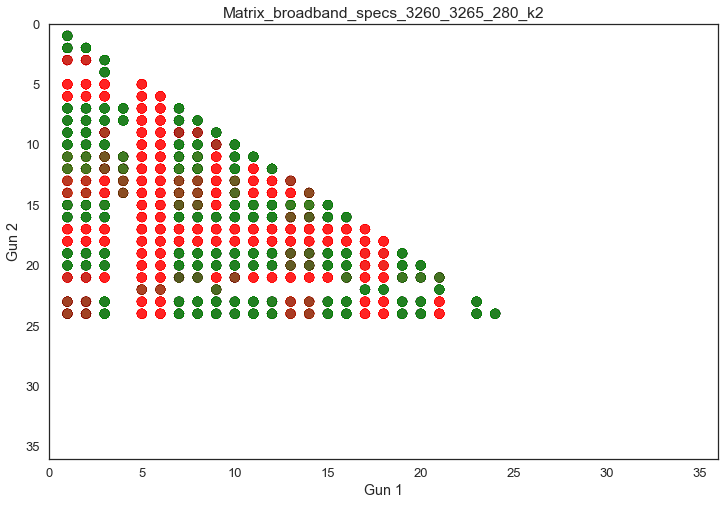

In [72]:
title2 = 'Matrix_broadband_specs_' + mastermatrix + '_' + nucver + '_' + kernel
plotmatrix_combined(2, stat_two_gun.gun1_num, stat_two_gun.gun2_num, stat_two_gun.bb_Legal, stat_one_gun.gun1_num, stat_one_gun.gun1_num, stat_one_gun.bb_Legal, stat_spare_gun.gun1_num, stat_spare_gun.gun2_num, stat_spare_gun.bb_Legal, title2 )

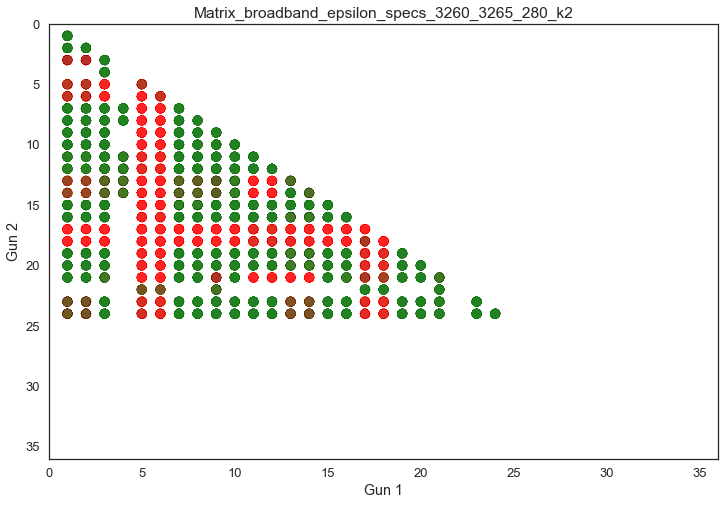

In [73]:
title3 = 'Matrix_broadband_epsilon_specs_' + mastermatrix + '_' + nucver + '_' + kernel
plotmatrix_combined(3, stat_two_gun.gun1_num, stat_two_gun.gun2_num, stat_two_gun.bb_eps_Legal, stat_one_gun.gun1_num, stat_one_gun.gun1_num, stat_one_gun.bb_eps_Legal, stat_spare_gun.gun1_num, stat_spare_gun.gun2_num, stat_spare_gun.bb_eps_Legal, title3 )

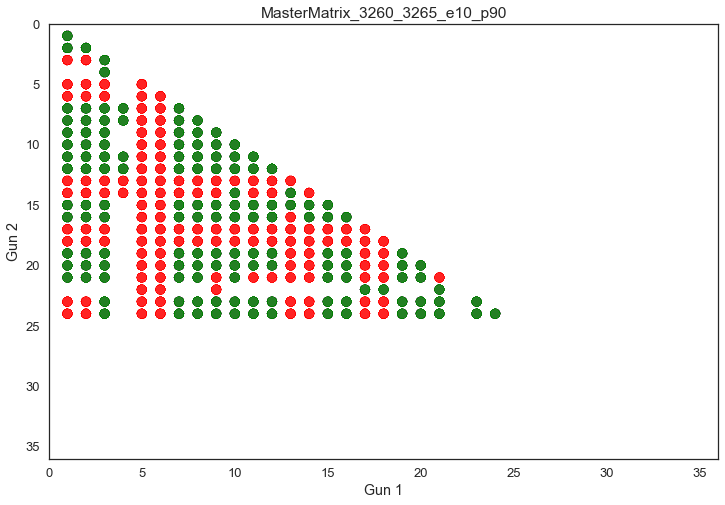

In [74]:
title4 = 'MasterMatrix_' + mastermatrix + '_e' + str(int(epsilon*100)) + '_p' + str(int(legal_if_ratio*100))
plotmatrix_combined(4, stat_two_gun.gun1_num, stat_two_gun.gun2_num, stat_two_gun.MM_Legal, stat_one_gun.gun1_num, stat_one_gun.gun1_num, stat_one_gun.MM_Legal, stat_spare_gun.gun1_num, stat_spare_gun.gun2_num, stat_spare_gun.MM_Legal, title4 )

Do some counting for QC

In [75]:
print("Number of combinations for all(raw) combinations (one gun, two gun, spare, one gun after substitution, second substitution)")
print(len(stat_one_gun), len(stat_two_gun), len(stat_spare_gun), len(stat_one_gun_after_subst), len(stat_spare_gun_after_subst))
print("Number of combinations for legal combinations wrt MasterMatrix")
print(len(stat_one_gun[stat_one_gun.MM_Legal]), len(stat_two_gun[stat_two_gun.MM_Legal]), len(stat_spare_gun[stat_spare_gun.MM_Legal]), len(stat_one_gun_after_subst[stat_one_gun_after_subst.MM_Legal]), len(stat_spare_gun_after_subst[stat_spare_gun_after_subst.MM_Legal]))
print("Number of combinations for legal combinations wrt Broadband specs")
print(len(stat_one_gun[stat_one_gun.bb_Legal]), len(stat_two_gun[stat_two_gun.bb_Legal]), len(stat_spare_gun[stat_spare_gun.bb_Legal]), len(stat_one_gun_after_subst[stat_one_gun_after_subst.bb_Legal]), len(stat_spare_gun_after_subst[stat_spare_gun_after_subst.bb_Legal]))
print("Number of combinations for legal combinations wrt Conventional specs")
print(len(stat_one_gun[stat_one_gun.cc_Legal]), len(stat_two_gun[stat_two_gun.cc_Legal]), len(stat_spare_gun[stat_spare_gun.cc_Legal]), len(stat_one_gun_after_subst[stat_one_gun_after_subst.cc_Legal]), len(stat_spare_gun_after_subst[stat_spare_gun_after_subst.cc_Legal]))

Number of combinations for all(raw) combinations (one gun, two gun, spare, one gun after substitution, second substitution)
2640 27720 1560 32760 10080
Number of combinations for legal combinations wrt MasterMatrix
1800 13920 960 22680 6120
Number of combinations for legal combinations wrt Broadband specs
2003 12851 1224 18946 5422
Number of combinations for legal combinations wrt Conventional specs
2236 15865 1344 19510 5424


Here comes the functions that do the matplotlib plots:

In [76]:
def figplot(figno, dataset_all, dataset_filt, figtitle, filename):
    sns.set_style("darkgrid")
    sns.set_palette("Paired")
    plt.figure(figno, figsize=(16, 12))
    plt.suptitle(figtitle, fontsize=16)
    plt.subplot(321)
    plt.hist(dataset_all['MaxPhase'], bins=40, range=(0, 40), alpha=0.6, label='all')
    plt.hist(dataset_filt['MaxPhase'], bins=40, range=(0, 40), alpha=0.6, label='legal')
    plt.axvline(x=20)
    plt.legend()
    plt.title('MaxPhase')

    plt.subplot(323)
    plt.hist(dataset_all['MaxdB'], bins=30, range=(0, 6), alpha=0.6, label='all')
    plt.hist(dataset_filt['MaxdB'], bins=30, range=(0, 6), alpha=0.6, label='legal')
    plt.axvline(x=3)
    plt.legend()
    plt.title('MaxdB')

    plt.subplot(325)
    plt.hist(dataset_all['AvgdB'], bins=40, range=(0, 1), alpha=0.6, label='all')
    plt.hist(dataset_filt['AvgdB'], bins=40, range=(0, 1), alpha=0.6, label='legal')
    plt.axvline(x=0.85)
    plt.legend()
    plt.title('AvgdB')

    plt.subplot(322)
    plt.hist(dataset_all['x-corr'], bins=40, range=(0.99, 1), alpha=0.6, label='all')
    plt.hist(dataset_filt['x-corr'], bins=40, range=(0.99, 1), alpha=0.6, label='legal')
    plt.axvline(x=0.998)
    plt.legend()
    plt.title('X-corr')

    plt.subplot(324)
    plt.hist(dataset_all['MaxdB-cc'], bins=30, range=(0, 6), alpha=0.6, label='all')
    plt.hist(dataset_filt['MaxdB-cc'], bins=30, range=(0, 6), alpha=0.6, label='legal')
    plt.axvline(x=3)
    plt.legend()
    plt.title('MaxdB-cc')
#    plt.hist(dataset_all['Peakch'], bins=24, range=(-10, 2), alpha=0.6, label='all')
#    plt.hist(dataset_filt['Peakch'], bins=24, range=(-10, 2), alpha=0.6, label='legal')
#    plt.axvline(x=-10)
#    plt.legend()
#    plt.title('Peakch %')

    plt.subplot(326)
    plt.hist(dataset_all['AvgdB-cc'], bins=40, range=(0, 1), alpha=0.6, label='all')
    plt.hist(dataset_filt['AvgdB-cc'], bins=40, range=(0, 1), alpha=0.6, label='legal')
    plt.axvline(x=0.85)
    plt.legend()
    plt.title('AvgdB-cc')
#    plt.hist(dataset_all['PtoBch'], bins=25, range=(-40, 10), alpha=0.6, label='all')
#    plt.hist(dataset_filt['PtoBch'], bins=25, range=(-40, 10), alpha=0.6, label='legal')
#    plt.axvline(x=-10)
#    plt.axvline(x=-15)
#    plt.legend()
#    plt.title('PtoBch %')
    filename = add_zero(figno) + '_' + filename + ".png"
    plt.savefig(filename)
    plt.show()


First plot is of all two gun dropouts

In [77]:
def figplot_peak_bubble(figno, dataset_all, dataset_filt, figtitle, filename):
    sns.set_style("darkgrid")
    sns.set_palette("Paired")
    plt.figure(figno, figsize=(16, 12))
    plt.suptitle(figtitle, fontsize=16)
    plt.subplot(321)
    plt.hist(dataset_all['Peak'], bins=40, range=(50, 90), alpha=0.6, label='all')
    plt.hist(dataset_filt['Peak'], bins=40, range=(50, 90), alpha=0.6, label='legal')
    plt.legend()
    plt.title('Peak')

    plt.subplot(322)
    plt.hist(dataset_all['PtoB'], bins=40, range=(5, 45), alpha=0.6, label='all')
    plt.hist(dataset_filt['PtoB'], bins=40, range=(5, 45), alpha=0.6, label='legal')
    plt.legend()
    plt.title('PtoB')

    plt.subplot(323)
    plt.hist(dataset_all['Peakch'], bins=24, range=(-10, 2), alpha=0.6, label='all')
    plt.hist(dataset_filt['Peakch'], bins=24, range=(-10, 2), alpha=0.6, label='legal')
    plt.axvline(x=-10)
    plt.legend()
    plt.title('Peakch')

    plt.subplot(324)
    plt.hist(dataset_all['PtoBch'], bins=30, range=(-40, 20), alpha=0.6, label='all')
    plt.hist(dataset_filt['PtoBch'], bins=30, range=(-40, 20), alpha=0.6, label='legal')
    plt.axvline(x=-10)
    plt.legend()
    plt.title('PtoBch')
    
    plt.subplot(325)
    plt.hist(dataset_all['Bubble'], bins=30, range=(0, 6), alpha=0.6, label='all')
    plt.hist(dataset_filt['Bubble'], bins=30, range=(0, 6), alpha=0.6, label='legal')
    plt.legend()
    plt.title('Bubble')
    
    plt.subplot(326)
    plt.hist(dataset_all['x-corr'], bins=40, range=(0.99, 1), alpha=0.6, label='all')
    plt.hist(dataset_filt['x-corr'], bins=40, range=(0.99, 1), alpha=0.6, label='legal')
    plt.axvline(x=0.998)
    plt.legend()
    plt.title('X-corr')

    
    filename = add_zero(figno) + '_' + filename + ".png"
    plt.savefig(filename)
    plt.show()

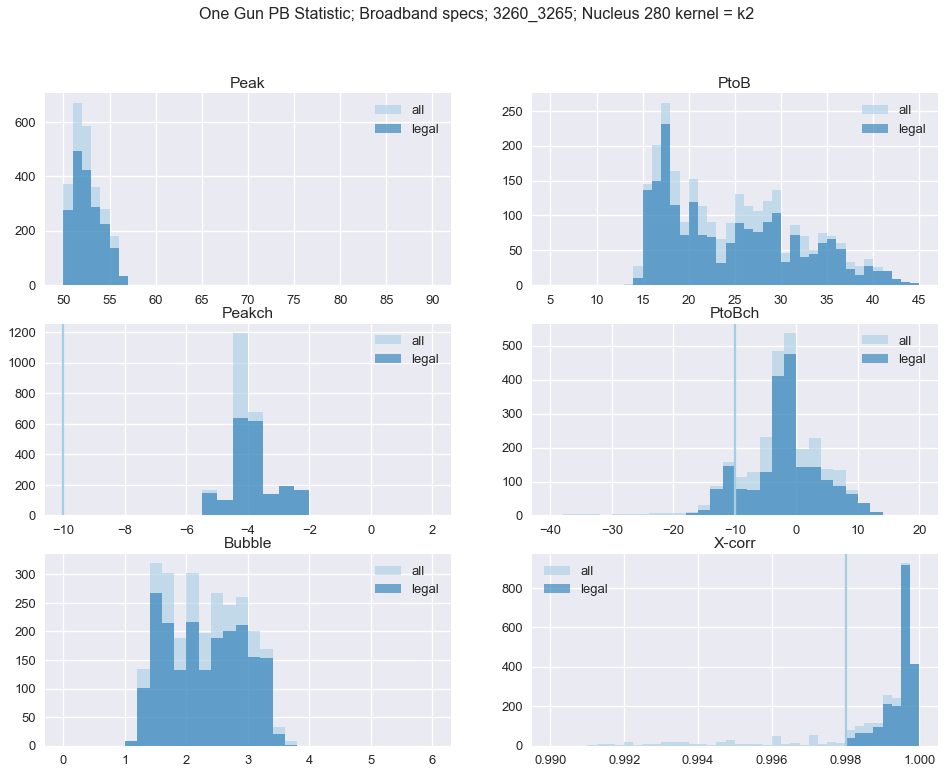

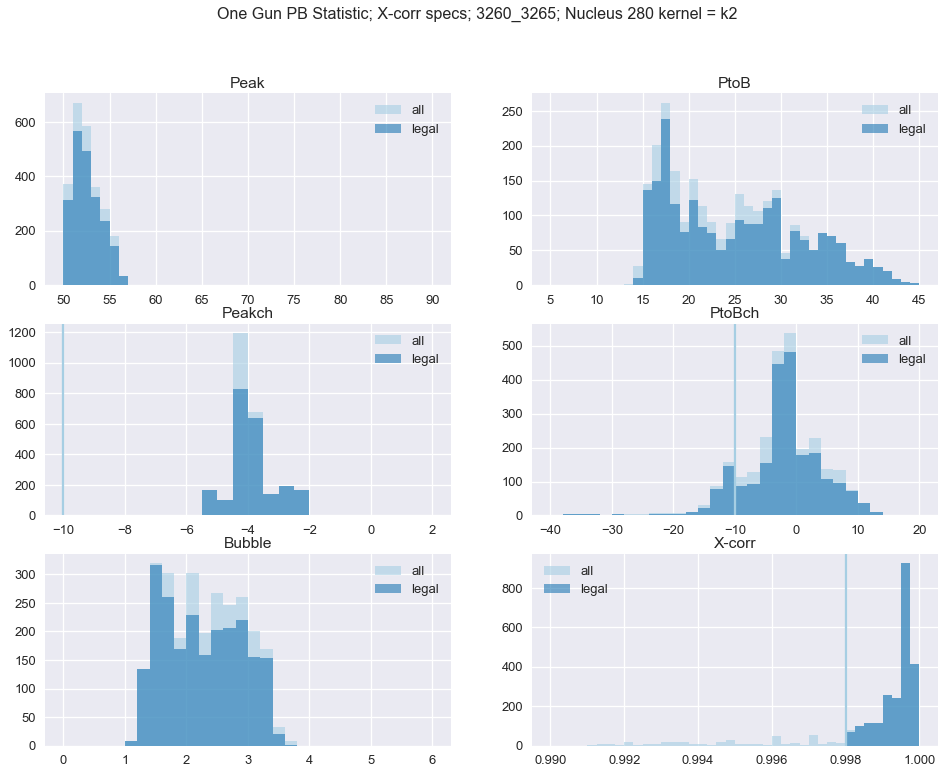

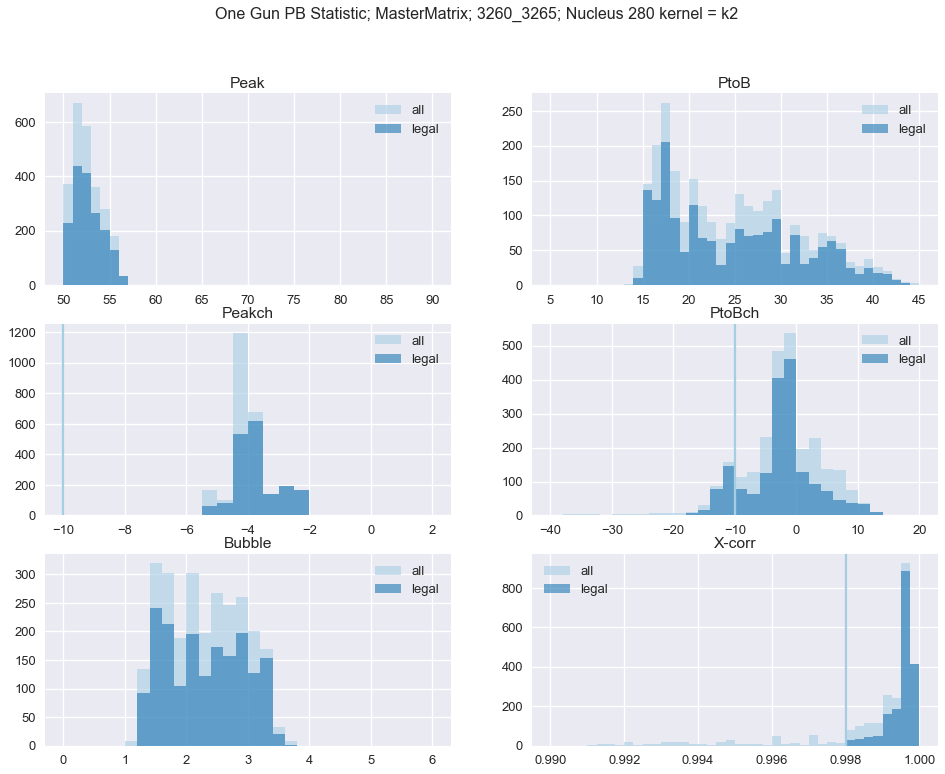

In [78]:
title5 = 'One Gun PB Statistic; Broadband specs; ' + mastermatrix + '; Nucleus ' + nucver + ' kernel = ' + kernel
title6 = 'One Gun PB Statistic; X-corr specs; ' + mastermatrix + '; Nucleus ' + nucver + ' kernel = ' + kernel
title7 = 'One Gun PB Statistic; MasterMatrix; ' + mastermatrix + '; Nucleus ' + nucver + ' kernel = ' + kernel
filename5 = 'One_Gun_PB_Stats_' + mastermatrix + '_broadband_specs_' + nucver + '_' + kernel
filename6 = 'One_Gun_PB_Stats_' + mastermatrix + '_xcorr_specs_' + nucver + '_' + kernel
filename7 = 'One_Gun_PB_Stats_' + mastermatrix + '_MasterMatrix_' + nucver + '_' + kernel
figplot_peak_bubble(5, stat_one_gun, stat_one_gun[stat_one_gun.bb_Legal], title5, filename5)
figplot_peak_bubble(6, stat_one_gun, stat_one_gun[stat_one_gun.cc_Legal], title6, filename6) 
figplot_peak_bubble(7, stat_one_gun, stat_one_gun[stat_one_gun.MM_Legal], title7, filename7)

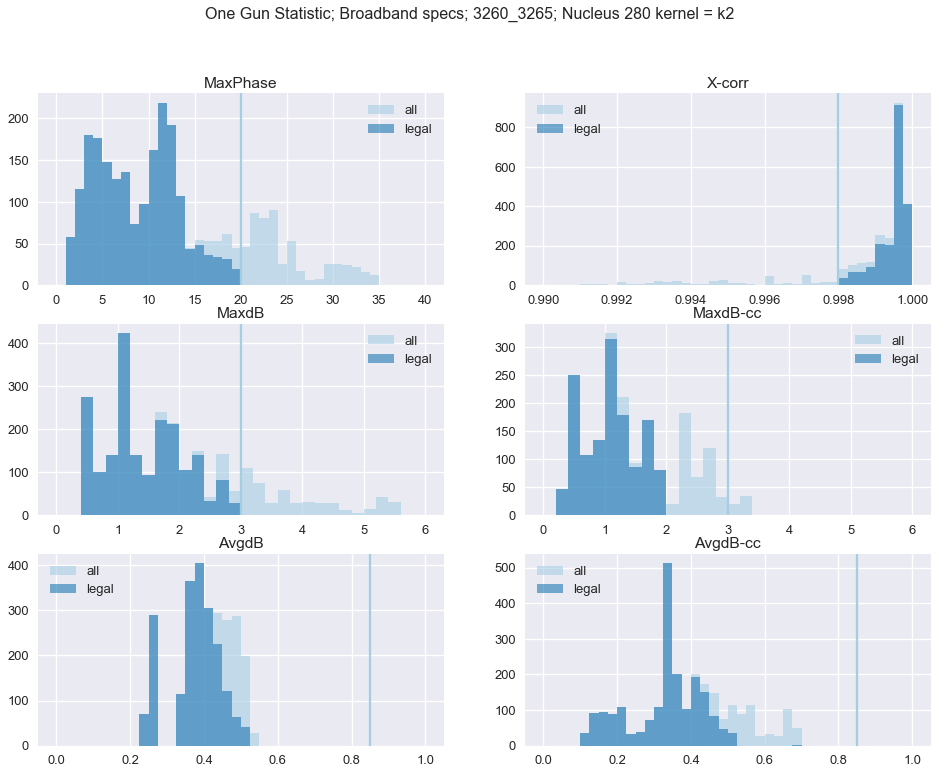

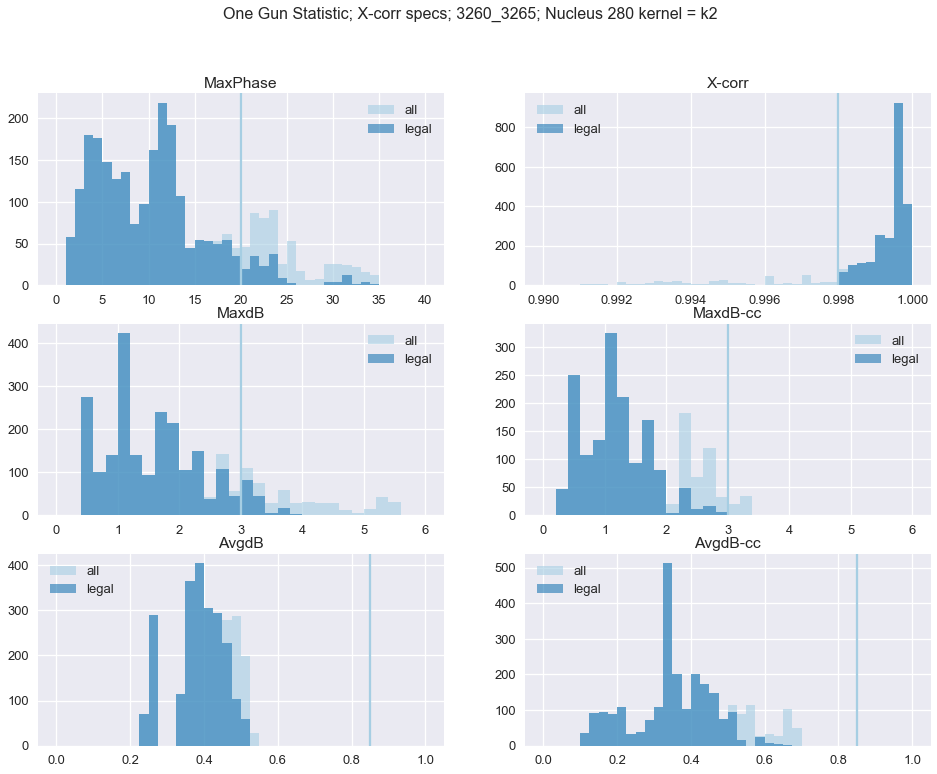

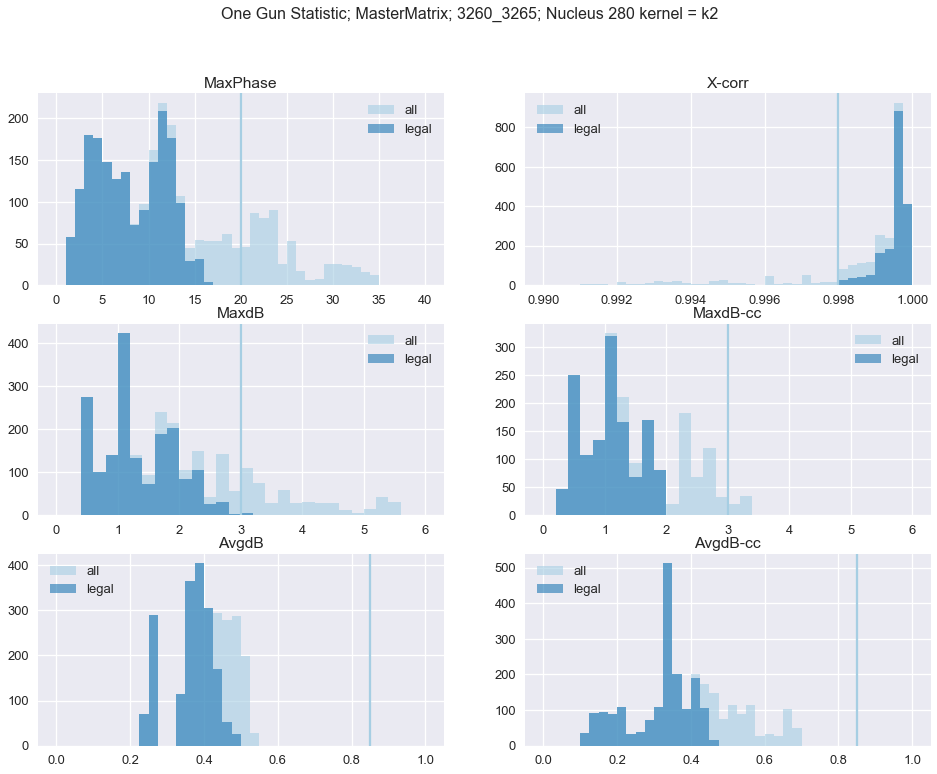

In [79]:
title8 = 'One Gun Statistic; Broadband specs; ' + mastermatrix + '; Nucleus ' + nucver + ' kernel = ' + kernel
title9 = 'One Gun Statistic; X-corr specs; ' + mastermatrix + '; Nucleus ' + nucver + ' kernel = ' + kernel
title10 = 'One Gun Statistic; MasterMatrix; ' + mastermatrix + '; Nucleus ' + nucver + ' kernel = ' + kernel
filename8 = 'One_Gun_Stats_' + mastermatrix + '_broadband_specs'  + '_' + nucver + '_' + kernel
filename9 = 'One_Gun_Stats_' + mastermatrix + '_xcorr_specs'  + '_' + nucver + '_' + kernel
filename10 = 'One_Gun_Stats_' + mastermatrix + '_MasterMatrix_' + nucver + '_' + kernel
figplot(8, stat_one_gun, stat_one_gun[stat_one_gun.bb_Legal], title8, filename8 )
figplot(9, stat_one_gun, stat_one_gun[stat_one_gun.cc_Legal], title9, filename9 )
figplot(10, stat_one_gun, stat_one_gun[stat_one_gun.MM_Legal], title10, filename10 )

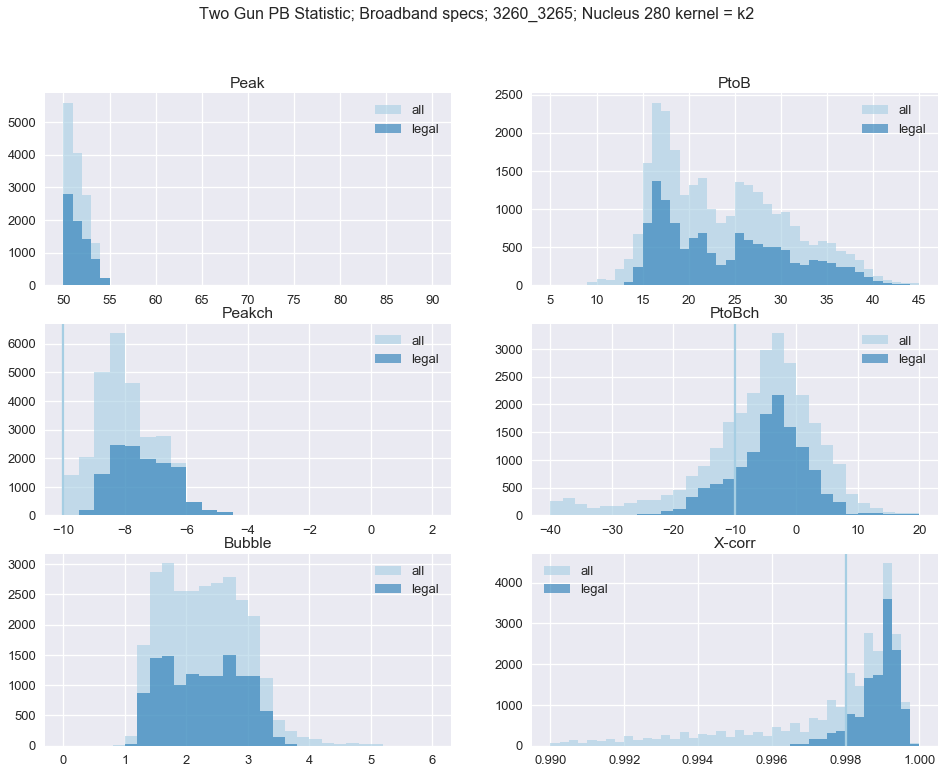

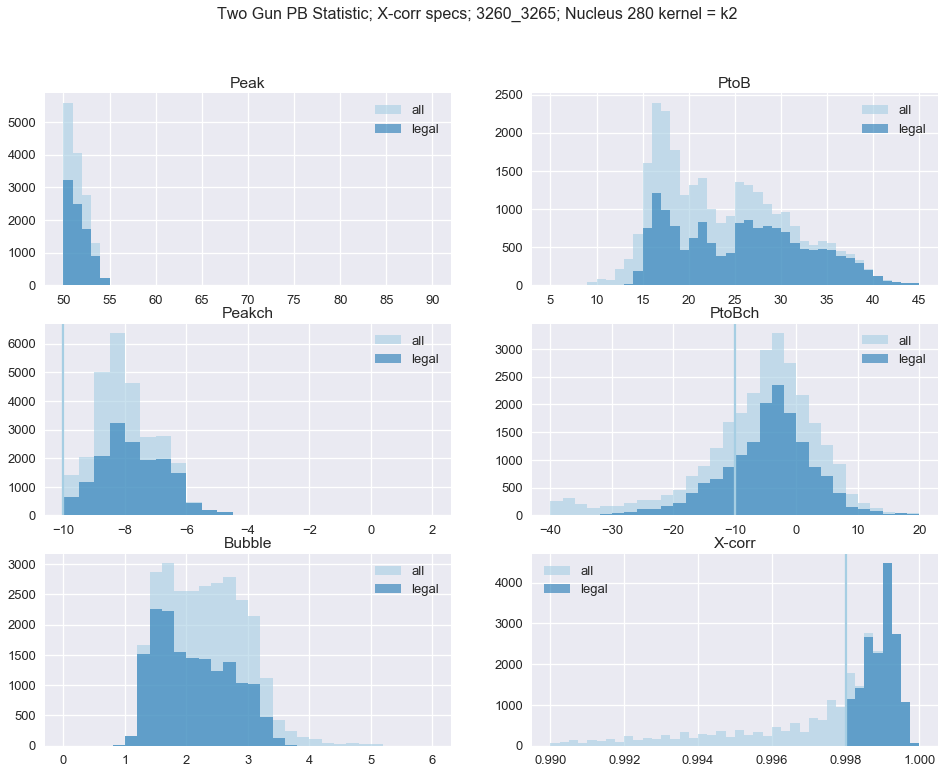

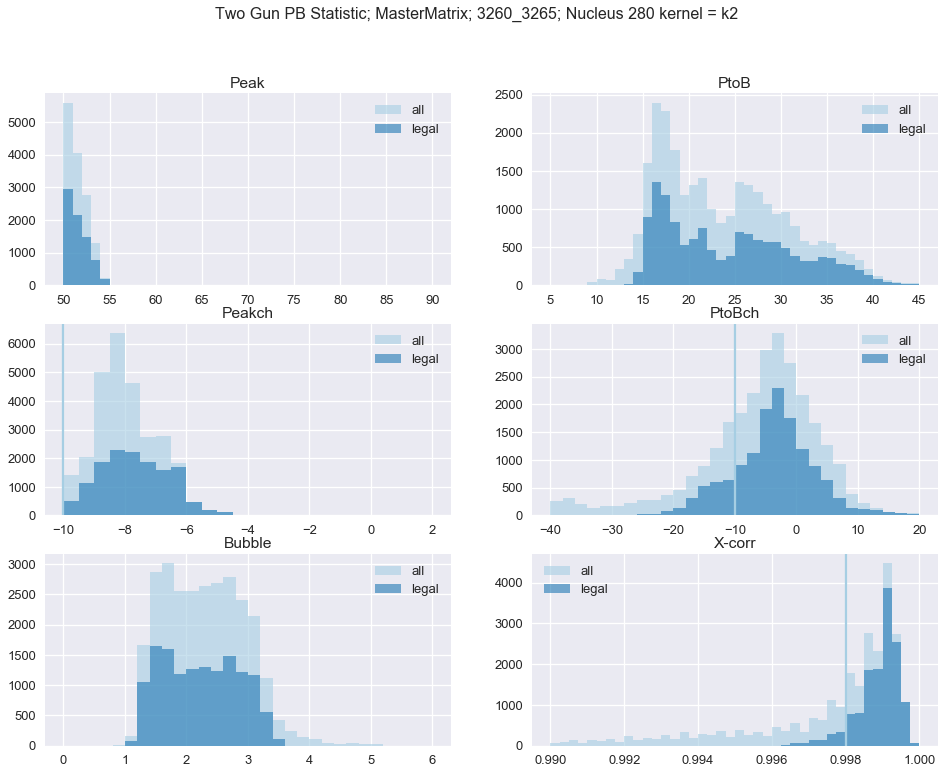

In [80]:
title11 = 'Two Gun PB Statistic; Broadband specs; ' + mastermatrix + '; Nucleus ' + nucver + ' kernel = ' + kernel
title12 = 'Two Gun PB Statistic; X-corr specs; ' + mastermatrix + '; Nucleus ' + nucver + ' kernel = ' + kernel
title13 = 'Two Gun PB Statistic; MasterMatrix; ' + mastermatrix + '; Nucleus ' + nucver + ' kernel = ' + kernel
filename11 = 'Two_Gun_PB_Stats_' + mastermatrix + '_broadband_specs_' + nucver + '_' + kernel
filename12 = 'Two_Gun_PB_Stats_' + mastermatrix + '_xcorr_specs_' + nucver + '_' + kernel
filename13 = 'Two_Gun_PB_Stats_' + mastermatrix + '_MasterMatrix_' + nucver + '_' + kernel
figplot_peak_bubble(11, stat_two_gun, stat_two_gun[stat_two_gun.bb_Legal], title11, filename11)
figplot_peak_bubble(12, stat_two_gun, stat_two_gun[stat_two_gun.cc_Legal], title12, filename12) 
figplot_peak_bubble(13, stat_two_gun, stat_two_gun[stat_two_gun.MM_Legal], title13, filename13)

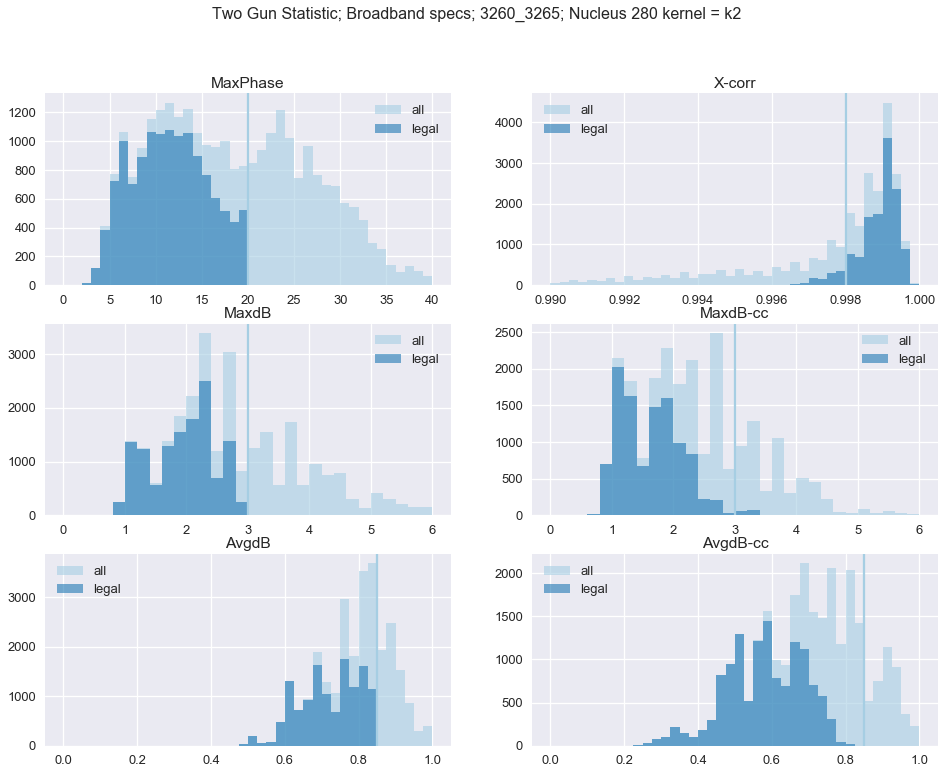

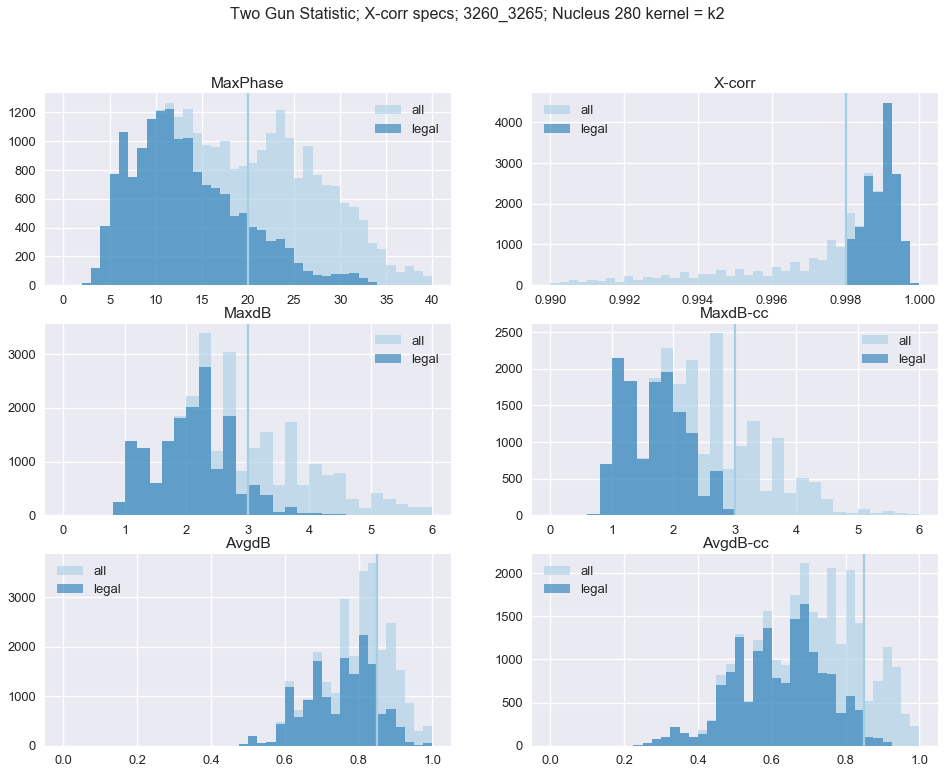

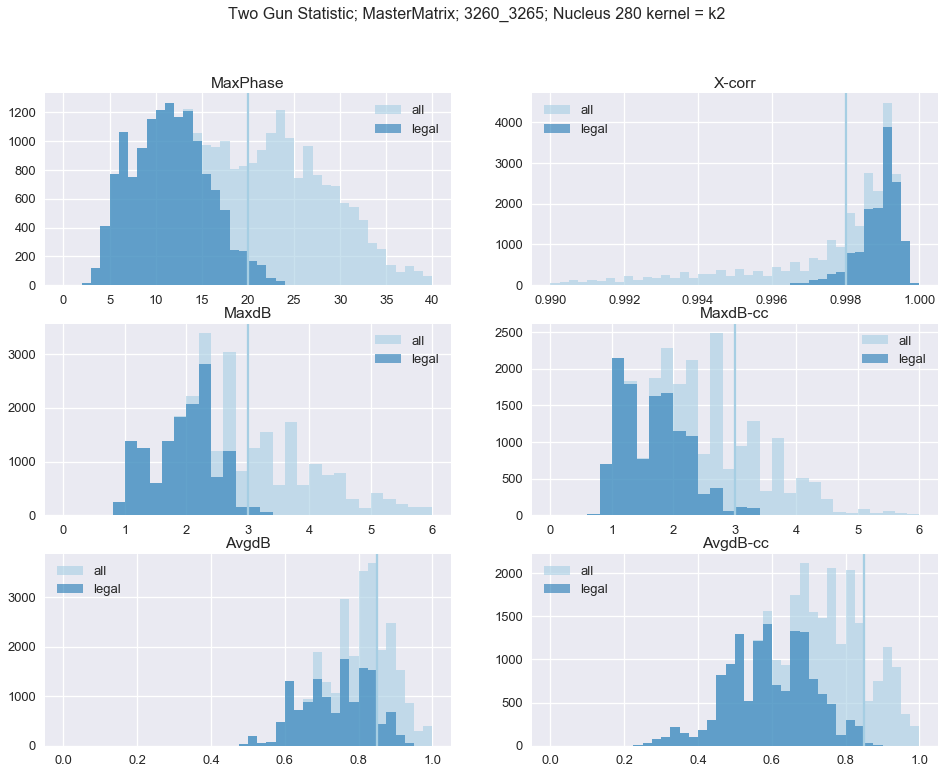

In [81]:
title14 = 'Two Gun Statistic; Broadband specs; ' + mastermatrix + '; Nucleus ' + nucver + ' kernel = ' + kernel
title15 = 'Two Gun Statistic; X-corr specs; ' + mastermatrix + '; Nucleus ' + nucver + ' kernel = ' + kernel
title16 = 'Two Gun Statistic; MasterMatrix; ' + mastermatrix + '; Nucleus ' + nucver + ' kernel = ' + kernel
filename14 = 'Two_Gun_Stats_' + mastermatrix + '_broadband_specs_' + kernel
filename15 = 'Two_Gun_Stats_' + mastermatrix + '_xcorr_specs_' + nucver + '_' + kernel
filename16 = 'Two_Gun_Stats_' + mastermatrix + '_MasterMatrix_' + nucver + '_' + kernel
figplot(14, stat_two_gun, stat_two_gun[stat_two_gun.bb_Legal], title14, filename14 )
figplot(15, stat_two_gun, stat_two_gun[stat_two_gun.cc_Legal], title15, filename15 )
figplot(16, stat_two_gun, stat_two_gun[stat_two_gun.MM_Legal], title16, filename16 )

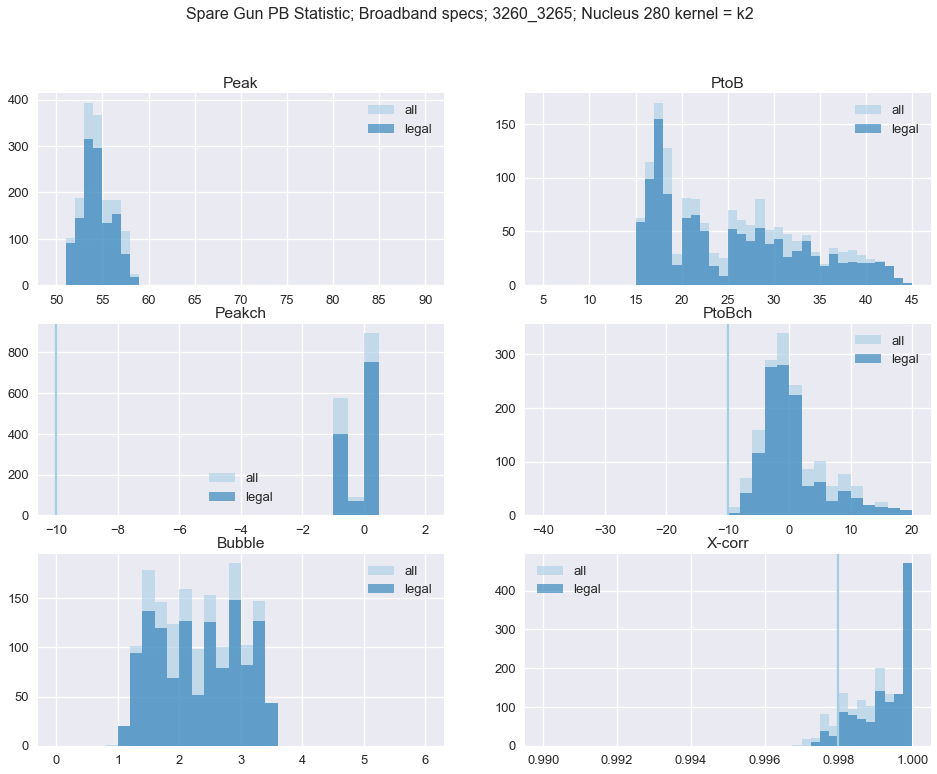

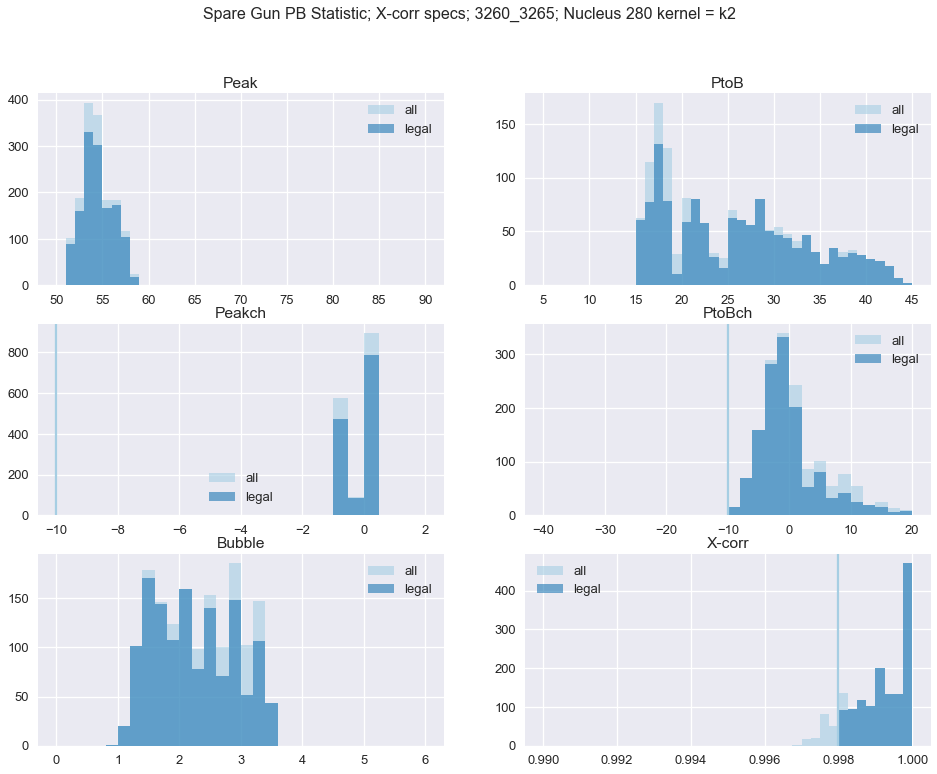

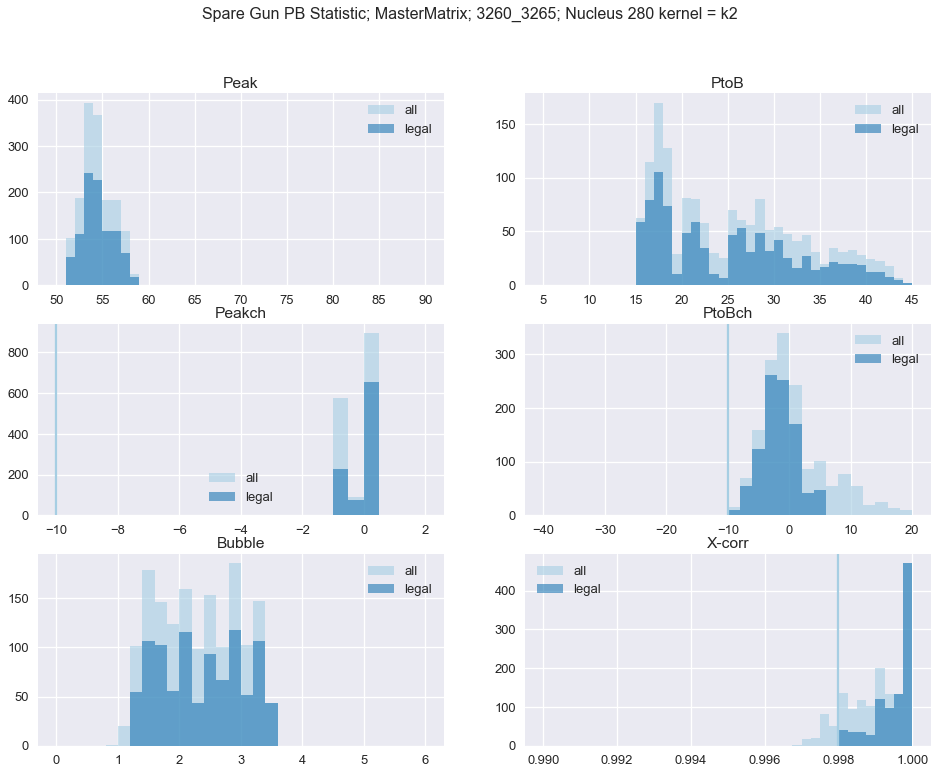

In [82]:
title17 = 'Spare Gun PB Statistic; Broadband specs; ' + mastermatrix + '; Nucleus ' + nucver + ' kernel = ' + kernel
title18 = 'Spare Gun PB Statistic; X-corr specs; ' + mastermatrix + '; Nucleus ' + nucver + ' kernel = ' + kernel
title19 = 'Spare Gun PB Statistic; MasterMatrix; ' + mastermatrix + '; Nucleus ' + nucver + ' kernel = ' + kernel
filename17 = 'Spare_Gun_PB_Stats_' + mastermatrix + '_broadband_specs_' + nucver + '_' + kernel
filename18 = 'Spare_Gun_PB_Stats_' + mastermatrix + '_xcorr_specs_' + nucver + '_' + kernel
filename19 = 'Spare_Gun_PB_Stats_' + mastermatrix + '_MasterMatrix_' + nucver + '_' + kernel
figplot_peak_bubble(17, stat_spare_gun, stat_spare_gun[stat_spare_gun.bb_Legal], title17, filename17)
figplot_peak_bubble(18, stat_spare_gun, stat_spare_gun[stat_spare_gun.cc_Legal], title18, filename18) 
figplot_peak_bubble(19, stat_spare_gun, stat_spare_gun[stat_spare_gun.MM_Legal], title19, filename19)

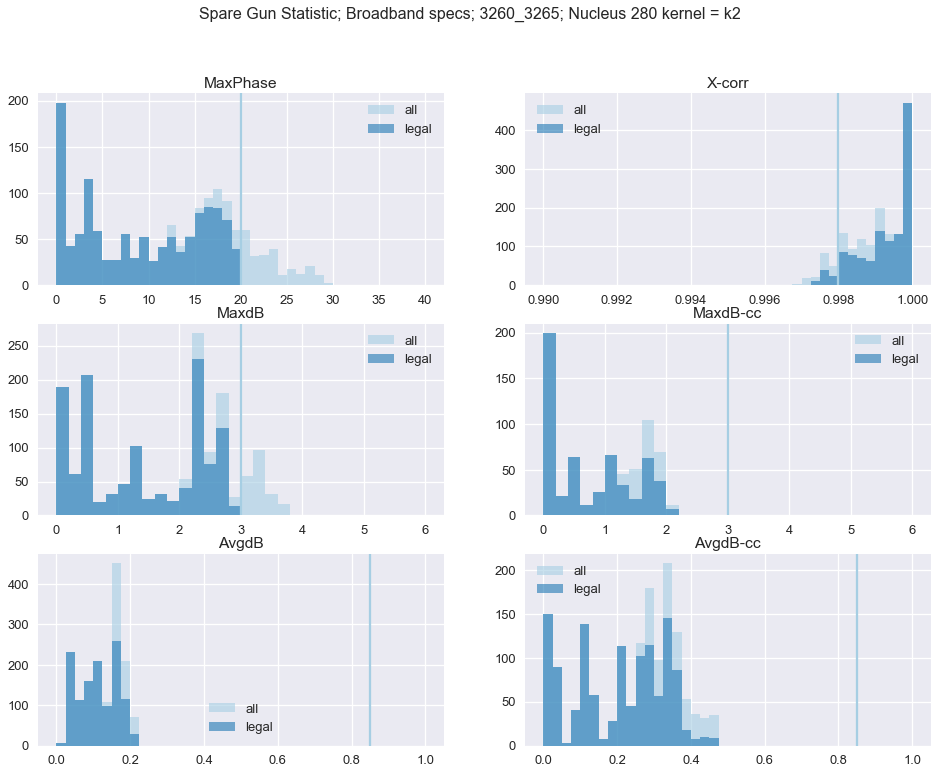

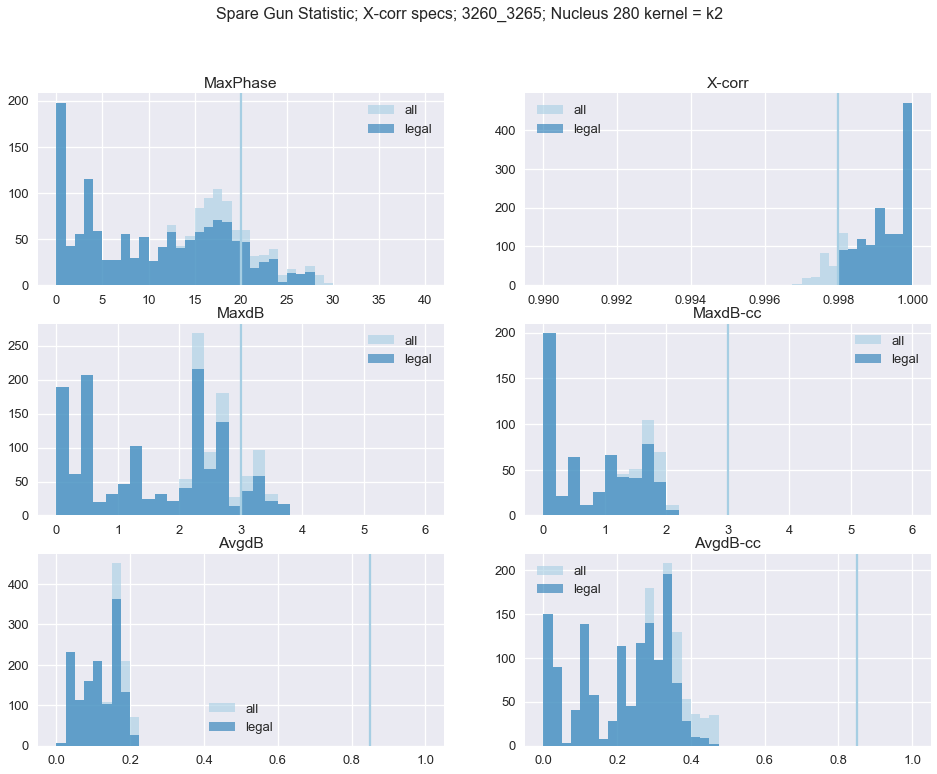

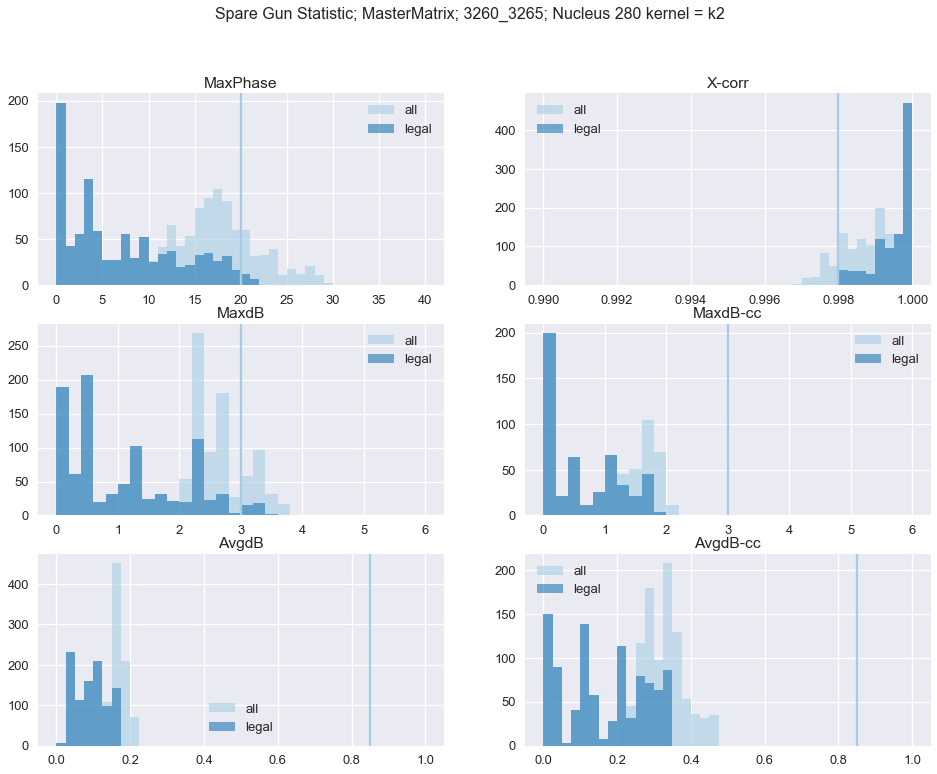

In [83]:
title20 = 'Spare Gun Statistic; Broadband specs; ' + mastermatrix + '; Nucleus ' + nucver + ' kernel = ' + kernel
title21 = 'Spare Gun Statistic; X-corr specs; ' + mastermatrix + '; Nucleus ' + nucver + ' kernel = ' + kernel
title22 = 'Spare Gun Statistic; MasterMatrix; ' + mastermatrix + '; Nucleus ' + nucver + ' kernel = ' + kernel
filename20 = 'Spare_Gun_Stats_' + mastermatrix + '_broadband_specs'  + '_' + nucver + '_' + kernel
filename21 = 'Spare_Gun_Stats_' + mastermatrix + '_xcorr_specs'  + '_' + nucver + '_' + kernel
filename22 = 'Spare_Gun_Stats_' + mastermatrix + '_MasterMatrix_' + nucver + '_' + kernel
figplot(20, stat_spare_gun, stat_spare_gun[stat_spare_gun.bb_Legal], title20, filename20 )
figplot(21, stat_spare_gun, stat_spare_gun[stat_spare_gun.cc_Legal], title21, filename21 )
figplot(22, stat_spare_gun, stat_spare_gun[stat_spare_gun.MM_Legal], title22, filename22 )

In [84]:
print(filename9)

One_Gun_Stats_3260_3265_xcorr_specs_280_k2


# Stop

#### Above plot comments
Typical tolerance specs are marked with vertical line for reference only.
Note that orange dataset (master matrix “passed”)is a sub-selection of blue dataset (partly transparent makes the orange slightly brown)
We observe that the master matrix drop out rule gets rid of most “bad” combinations, according to the current specs, but also some good ones that would be within the current specs.
The number of legal combinations that are above current specs are few and quite marginal.

Second plot is for single gun dropouts:

#### Above plot comments
Single gun dropouts are a lot more likely than two gun dropouts.
The Master Matrix rule is rejecting practically all bad combinations, according to traditional specs
Note: Spares not enabled

#### Above plot comments
All spare substitutions allowed, so light blue bars are completely obscures by darker blue bars.
We observe some substitutions that for some parameter combinations could be problematic.

For more in depth analysis and fancier plots (using Pyhton Seaborn module), we join the datasets. First, we'll strip off some columns before the join and add columns for Scenario (which can have the following values: "One gun dropoout", "Two gun dropout" and "Spare substitution") and for Status (which can have the following values: "All" or "Legal"). At the end, all the data are concatenated to a dataset (panda dataframe) called comb_data_bb (bb reflecting that this is the broadband dataset)

Then we repeat the process for the cc data (cross-correlation)

Just checking the size of the datasets (cc and bb datasets should have same length since both have same number of combinations)

Combining data using a join (left join, adding a suffix of "-cc" to identical column names, then dropping some redundant columns)

Inspecting some data. Note that the columns AvgdB and MaxdB contain data from the broadband modeling, whereas AvgdB-cc and MaxdB-cc contains the conventional spec values.

Split up the full dataframe in two separate dateaframes: one for legal combinations, one for all combinations.
The comb_data dataframe contain both "all" and "legal" combinations. Convenient when plotting with "hue"
The comb_data_legal contain only status = "legal"
The comb_data_all contain only status "All"

## Box Plot
The box plot (also known as a box-and-whisker plot) can tell us about how our dataset is distributed. It shows us the range of our dataset, gives us an idea about where a significant portion of our data lies, and whether or not any outliers are present.

How to interpret a box plot:

-The box represents the interquartile range (The difference between the upper and lower quartiles (Q3–Q1) of a data set. This range is used as a measure of data spread: spanning 50% of a data set and eliminating the influence of outliers (the highest and lowest quarters of a data set are removed).) 

-The line in the middle of the box is the median

-The end lines are the first and third quartiles (In order to determine the interquartile range, a data set is divided into four equal parts. Each separating value is called a quartile (the first, the second, etc.). The second quartile is the median)

-The diamonds show outliers


In [85]:
stat_one_gun.columns

Index(['index', 'droparray1', 'dropgun1', 'gunvolume1', 'AvgdB', 'MaxdB',
       'MaxPhase', 'filename', 'SourceVolume', 'GunType', 'Depth', 'Subsep',
       'Temperature', 'Peak', 'Peakch', 'PtoB', 'PtoBch', 'x-corr', 'AvgdB-cc',
       'MaxdB-cc', 'Bubble', 'dropgun1_str', 'gun1_unique', 'gun1_num',
       'Scenario', 'bb_Legal', 'cc_Legal', 'bb_eps_Legal', 'MM_Legal'],
      dtype='object')

In [86]:
stat_two_gun.columns

Index(['index', 'droparray1', 'dropgun1', 'droparray2', 'dropgun2',
       'gunvolume1', 'gunvolume2', 'AvgdB', 'MaxdB', 'MaxPhase', 'filename',
       'SourceVolume', 'GunType', 'Depth', 'Subsep', 'Temperature', 'Peak',
       'Peakch', 'PtoB', 'PtoBch', 'x-corr', 'AvgdB-cc', 'MaxdB-cc', 'Bubble',
       'dropgun1_str', 'dropgun2_str', 'gun1_unique', 'gun2_unique',
       'gun1_num', 'gun2_num', 'Scenario', 'bb_Legal', 'cc_Legal',
       'bb_eps_Legal', 'MM_Legal'],
      dtype='object')

In [87]:
stat_spare_gun.columns

Index(['index', 'droparray1', 'dropgun1', 'droparray2', 'dropgun2',
       'gunvolume1', 'gunvolume2', 'AvgdB', 'MaxdB', 'MaxPhase', 'filename',
       'SourceVolume', 'GunType', 'Depth', 'Subsep', 'Temperature', 'Peak',
       'Peakch', 'PtoB', 'PtoBch', 'x-corr', 'AvgdB-cc', 'MaxdB-cc', 'Bubble',
       'dropgun1_str', 'dropgun2_str', 'gun1_unique', 'gun2_unique',
       'gun1_num', 'gun2_num', 'Scenario', 'bb_Legal', 'cc_Legal',
       'bb_eps_Legal', 'MM_Legal'],
      dtype='object')

In [88]:
stat_spare_gun_after_subst.columns

Index(['index', 'droparray1', 'dropgun1', 'droparray2', 'dropgun2',
       'gunvolume1', 'gunvolume2', 'AvgdB', 'MaxdB', 'MaxPhase', 'filename',
       'SourceVolume', 'GunType', 'Depth', 'Subsep', 'Substscenario',
       'Temperature', 'Peak', 'Peakch', 'PtoB', 'PtoBch', 'x-corr', 'AvgdB-cc',
       'MaxdB-cc', 'Bubble', 'dropgun1_str', 'dropgun2_str', 'gun1_unique',
       'gun2_unique', 'gun1_num', 'gun2_num', 'Scenario', 'bb_Legal',
       'cc_Legal', 'MM_Legal'],
      dtype='object')

In [89]:
stat_one_gun_stripped = stat_one_gun.drop(columns=['droparray1', 'dropgun1', 'gunvolume1', 'filename', 'dropgun1_str', 'gun1_unique', 'gun1_num'])
stat_two_gun_stripped = stat_two_gun.drop(columns=['droparray1', 'dropgun1', 'gunvolume1', 'droparray2', 'dropgun2', 'gunvolume2', 'filename', 'dropgun1_str', 'dropgun2_str', 'gun1_unique', 'gun2_unique', 'gun1_num', 'gun2_num'])
stat_spare_gun_stripped = stat_spare_gun.drop(columns=['droparray1', 'dropgun1', 'gunvolume1', 'droparray2', 'dropgun2', 'gunvolume2', 'filename', 'dropgun1_str', 'dropgun2_str', 'gun1_unique', 'gun2_unique', 'gun1_num', 'gun2_num'])

In [90]:
combined_data = pd.concat([stat_one_gun_stripped, stat_two_gun_stripped, stat_spare_gun_stripped], ignore_index=True)

In [91]:
#combined_data

In [92]:
stat_one_gun_after_subst_stripped = stat_one_gun_after_subst.drop(columns=['droparray1', 'dropgun1', 'gunvolume1', 'filename', 'dropgun1_str', 'gun1_unique', 'gun1_num'])
stat_spare_gun_after_subst_stripped = stat_spare_gun_after_subst.drop(columns=['droparray1', 'dropgun1', 'gunvolume1', 'droparray2', 'dropgun2', 'gunvolume2', 'filename', 'dropgun1_str', 'dropgun2_str', 'gun1_unique', 'gun2_unique', 'gun1_num', 'gun2_num'])

In [93]:
combined_data_after_subst = pd.concat([stat_one_gun_after_subst_stripped, stat_spare_gun_after_subst_stripped], ignore_index=True)

In [94]:
sns.set_style("darkgrid")
sns.set_palette("pastel")
#sns.set_context("paper")
sns.set_context("talk")
sns.set_palette("Paired")
#plt.figure(figsize=(12,8))
#plt.axhline(20, color='red')
#sns.boxplot(data=comb_data, x='Scenario', y='MaxPhase', hue='Status');

For reference the 20 degree maxphase limit is plotted as a red line.
Observations:

One gun dropout (which is far more likely than two gun dropouts): All legal (master matrix filtered) or 100% of combinations are within the 20 phase spec

Two gun dropouts: More than 75% of legal dropouts are within spec

Spare gun dropouts: More than 75% of legal dropouts are within spec

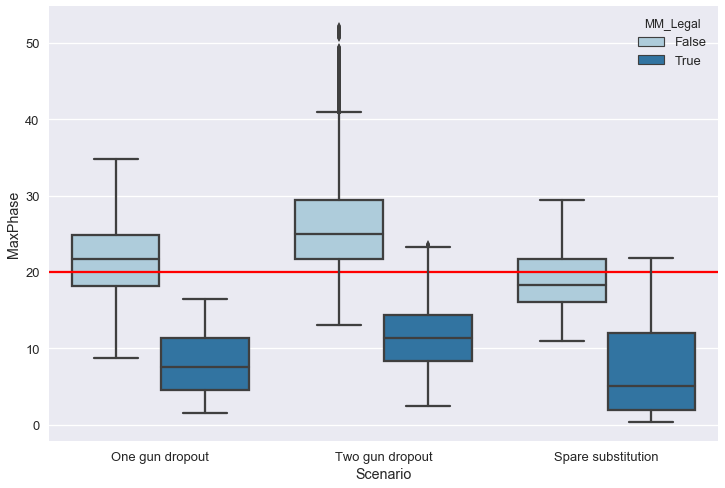

In [95]:
plt.figure(figsize=(12,8))
plt.axhline(20, color='red')
sns.boxplot(data=combined_data, x='Scenario', y='MaxPhase', hue='MM_Legal');

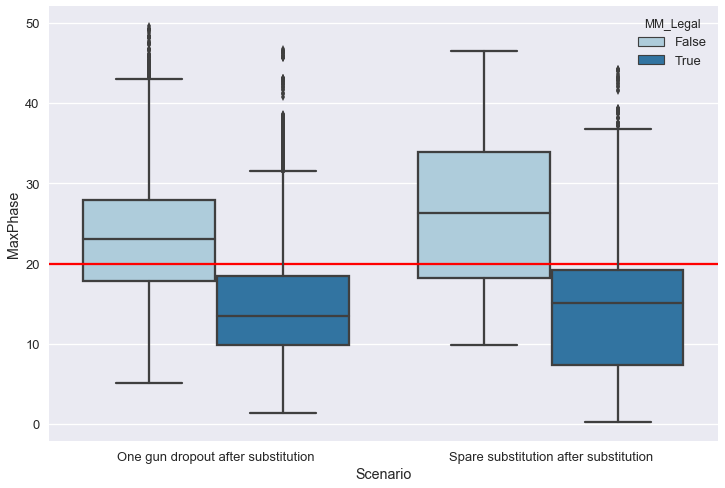

In [96]:
plt.figure(figsize=(12,8))
plt.axhline(20, color='red')
sns.boxplot(data=combined_data_after_subst, x='Scenario', y='MaxPhase', hue='MM_Legal');

## Violin Plots
Violin plots provide more information than box plots because instead of mapping each individual data point, we get an estimation of the dataset from the KDE (Kernel Density Estimation).

There are two KDE plots that are symmetrical along the center line.
A white dot represents the median.
The thick black line in the center of each violin represents the interquartile range.
The lines that extend from the center are the confidence intervals - just on the box plots, a violin plot also displays the 95% confidence interval.

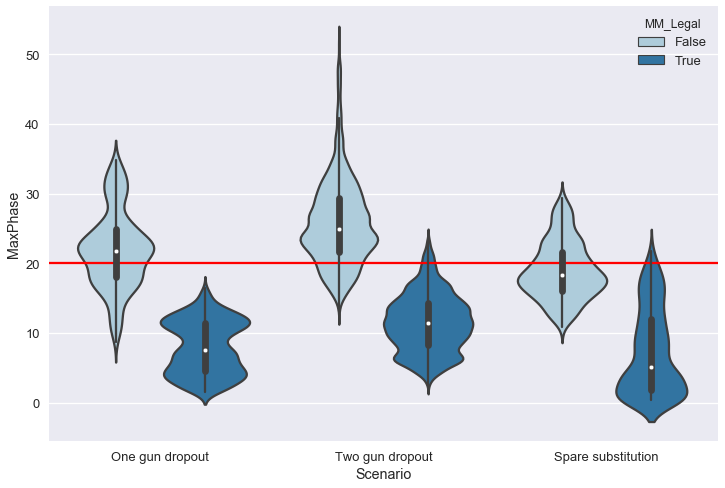

In [97]:
plt.figure(figsize=(12,8))
plt.axhline(20, color='red')
sns.violinplot(data=combined_data, x='Scenario', y='MaxPhase', hue='MM_Legal');

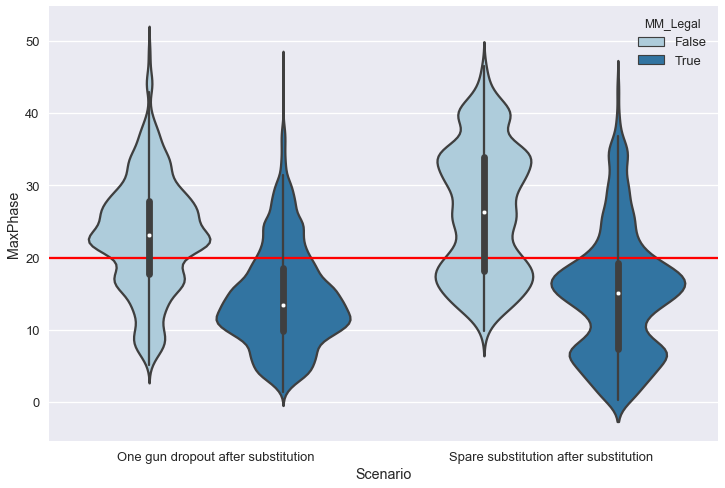

In [98]:
plt.figure(figsize=(12,8))
plt.axhline(20, color='red')
sns.violinplot(data=combined_data_after_subst, x='Scenario', y='MaxPhase', hue='MM_Legal');

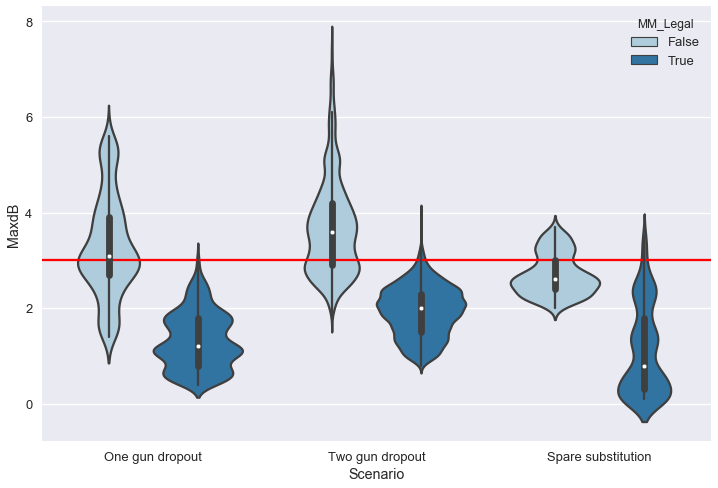

In [99]:
plt.figure(figsize=(12,8))
plt.axhline(3, color='red')
sns.violinplot(data=combined_data, x='Scenario', y='MaxdB', hue='MM_Legal');

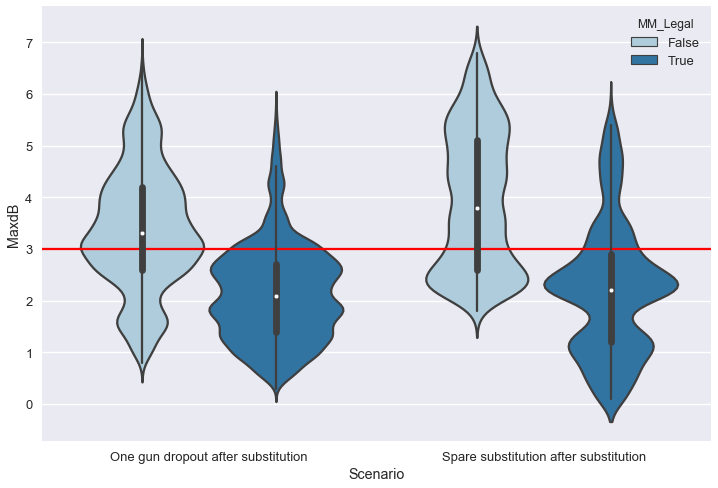

In [100]:
plt.figure(figsize=(12,8))
plt.axhline(3, color='red')
sns.violinplot(data=combined_data_after_subst, x='Scenario', y='MaxdB', hue='MM_Legal');

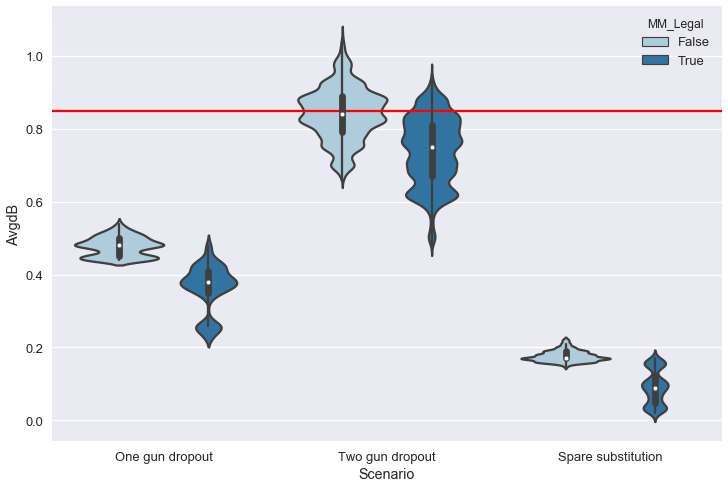

In [101]:
plt.figure(figsize=(12,8))
plt.axhline(0.85, color='red')
sns.violinplot(data=combined_data, x='Scenario', y='AvgdB', hue='MM_Legal');

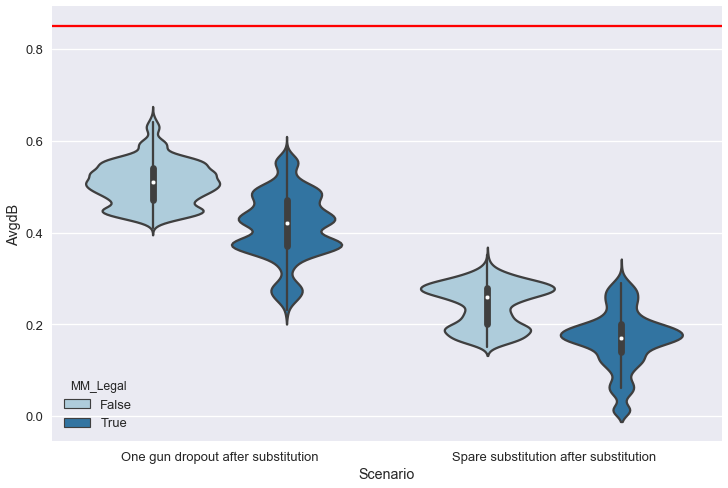

In [102]:
plt.figure(figsize=(12,8))
plt.axhline(0.85, color='red')
sns.violinplot(data=combined_data_after_subst, x='Scenario', y='AvgdB', hue='MM_Legal');

### Checking dependiencies with temperature and depth

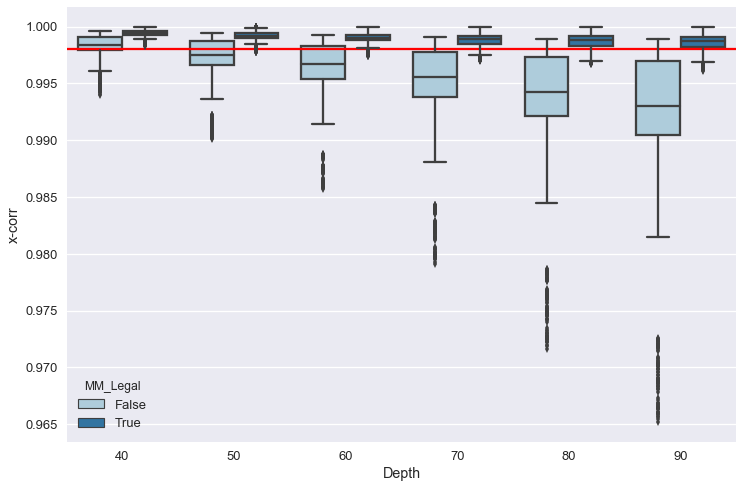

In [103]:
plt.figure(figsize=(12,8))
plt.axhline(0.998, color='red')
sns.boxplot(data=combined_data, x='Depth', y='x-corr', hue='MM_Legal');

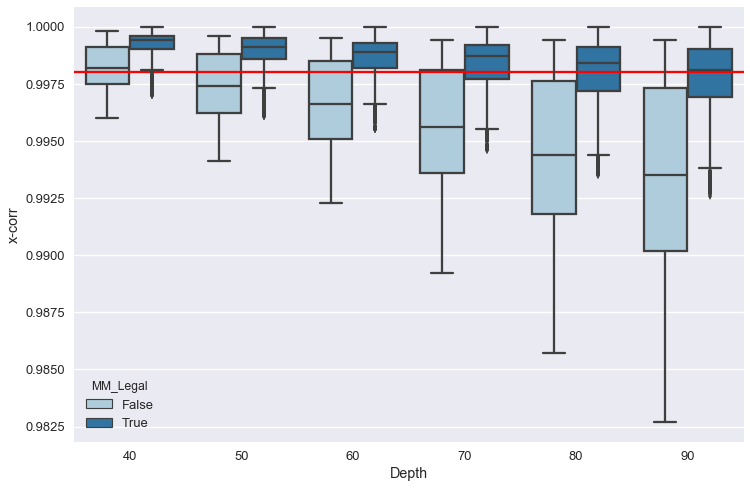

In [104]:
plt.figure(figsize=(12,8))
plt.axhline(0.998, color='red')
sns.boxplot(data=combined_data_after_subst, x='Depth', y='x-corr', hue='MM_Legal');

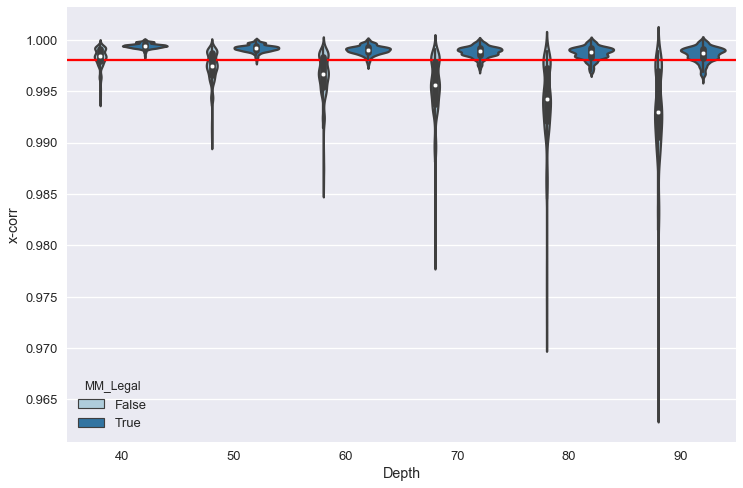

In [105]:
plt.figure(figsize=(12,8))
plt.axhline(0.998, color='red')
sns.violinplot(data=combined_data, x='Depth', y='x-corr', hue='MM_Legal');

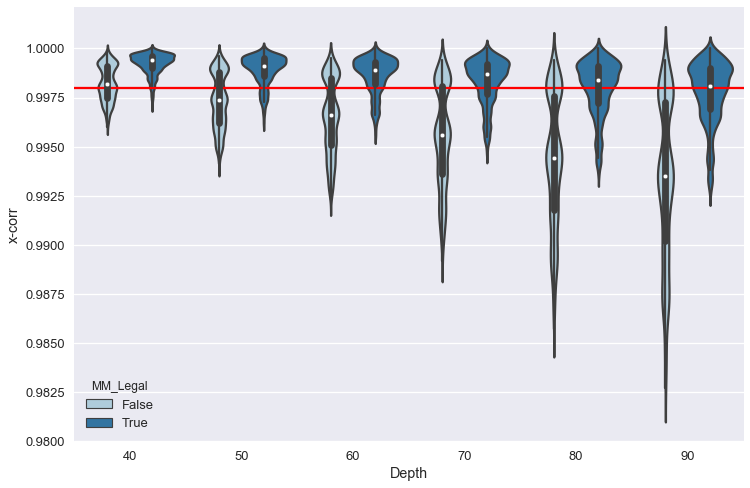

In [106]:
plt.figure(figsize=(12,8))
plt.axhline(0.998, color='red')
sns.violinplot(data=combined_data_after_subst, x='Depth', y='x-corr', hue='MM_Legal');

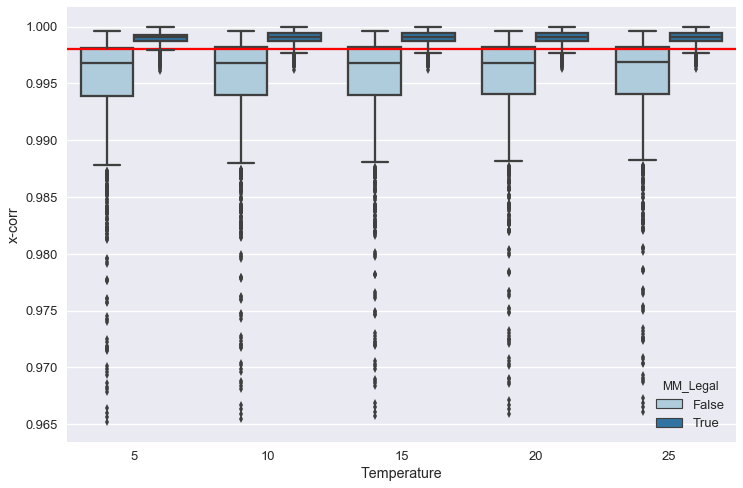

In [107]:
plt.figure(figsize=(12,8))
plt.axhline(0.998, color='red')
sns.boxplot(data=combined_data, x='Temperature', y='x-corr', hue='MM_Legal');

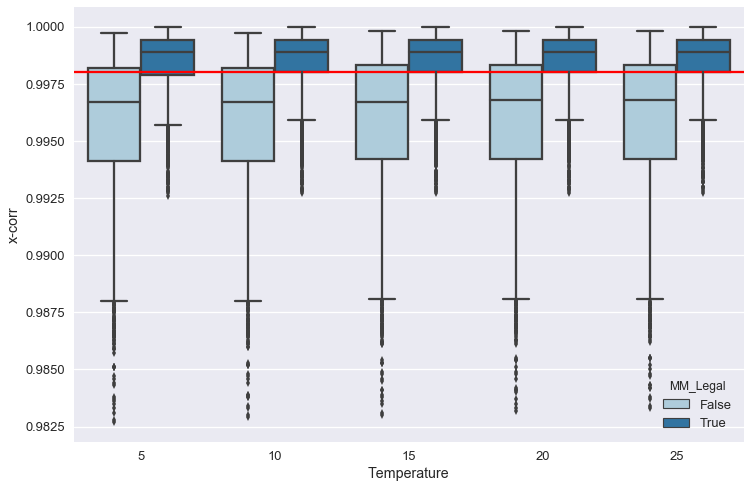

In [108]:
plt.figure(figsize=(12,8))
plt.axhline(0.998, color='red')
sns.boxplot(data=combined_data_after_subst, x='Temperature', y='x-corr', hue='MM_Legal');

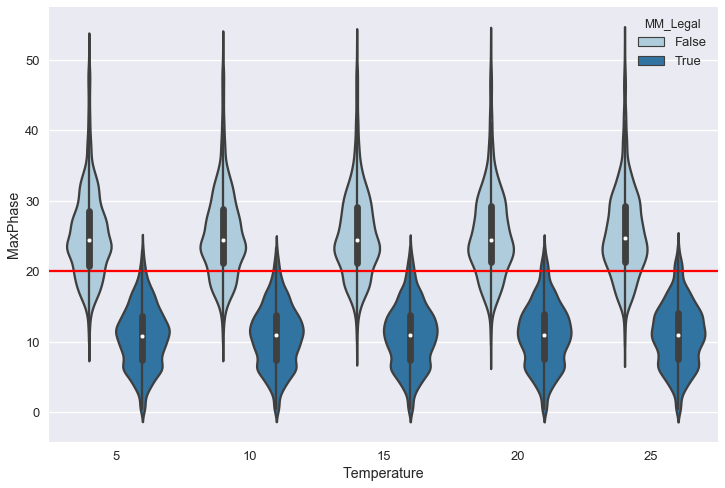

In [109]:
plt.figure(figsize=(12,8))
plt.axhline(20, color='red')
sns.violinplot(data=combined_data, x='Temperature', y='MaxPhase', hue='MM_Legal');

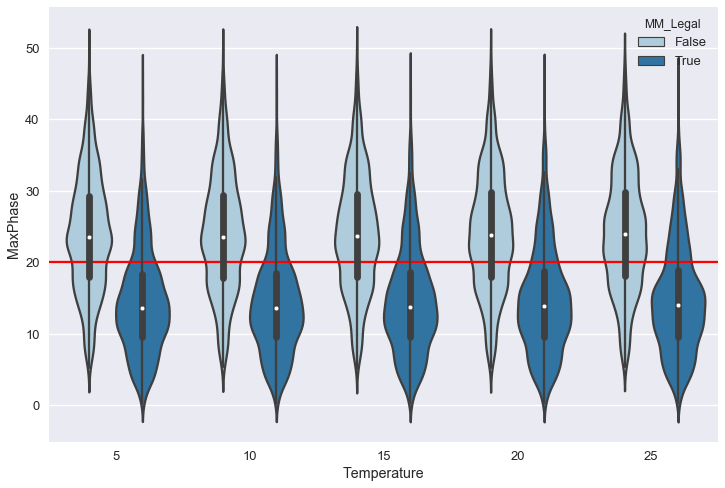

In [110]:
plt.figure(figsize=(12,8))
plt.axhline(20, color='red')
sns.violinplot(data=combined_data_after_subst, x='Temperature', y='MaxPhase', hue='MM_Legal');

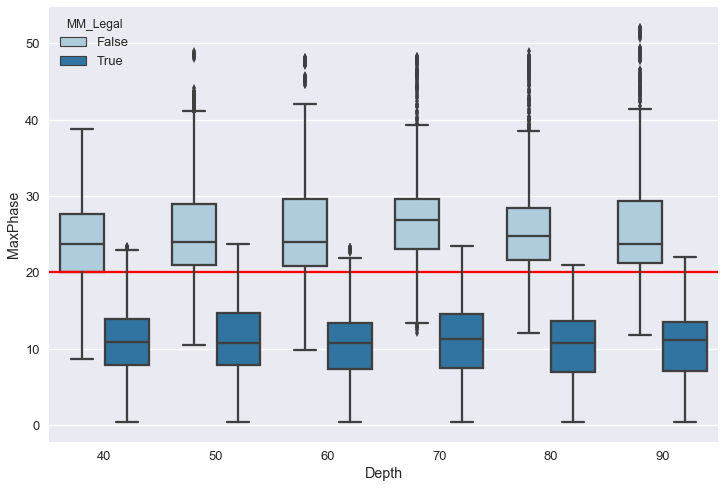

In [111]:
plt.figure(figsize=(12,8))
plt.axhline(20, color='red')
sns.boxplot(data=combined_data, x='Depth', y='MaxPhase', hue='MM_Legal');

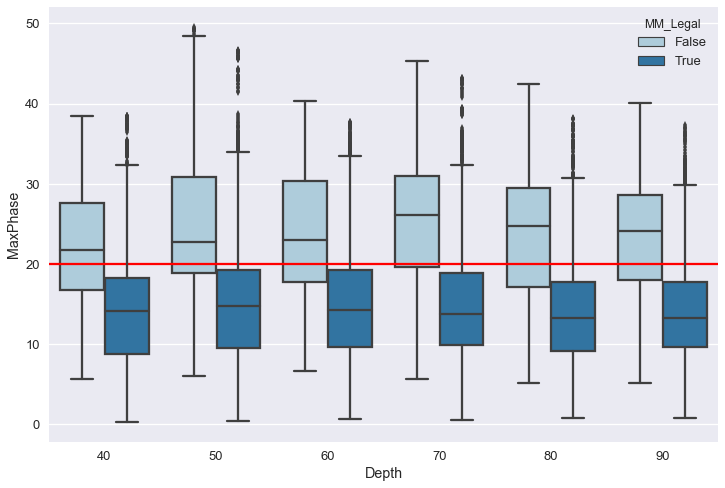

In [112]:
plt.figure(figsize=(12,8))
plt.axhline(20, color='red')
sns.boxplot(data=combined_data_after_subst, x='Depth', y='MaxPhase', hue='MM_Legal');

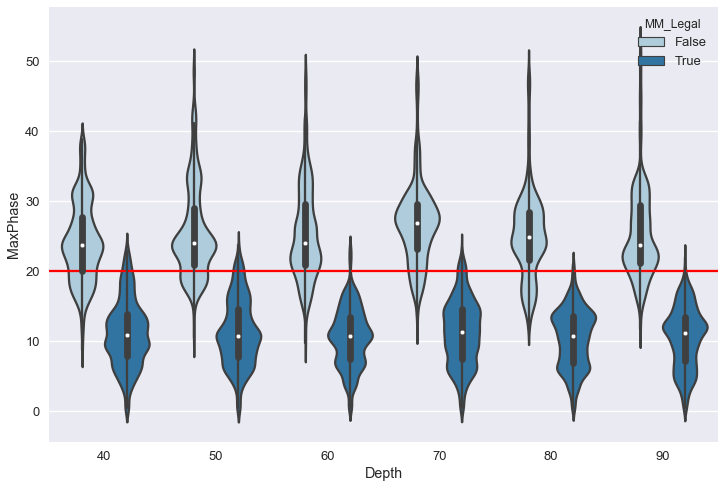

In [113]:
plt.figure(figsize=(12,8))
plt.axhline(20, color='red')
sns.violinplot(data=combined_data, x='Depth', y='MaxPhase', hue='MM_Legal');

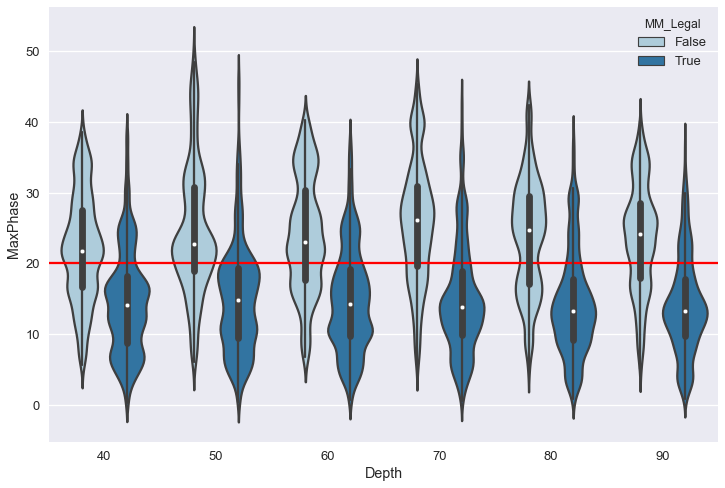

In [114]:
plt.figure(figsize=(12,8))
plt.axhline(20, color='red')
sns.violinplot(data=combined_data_after_subst, x='Depth', y='MaxPhase', hue='MM_Legal');

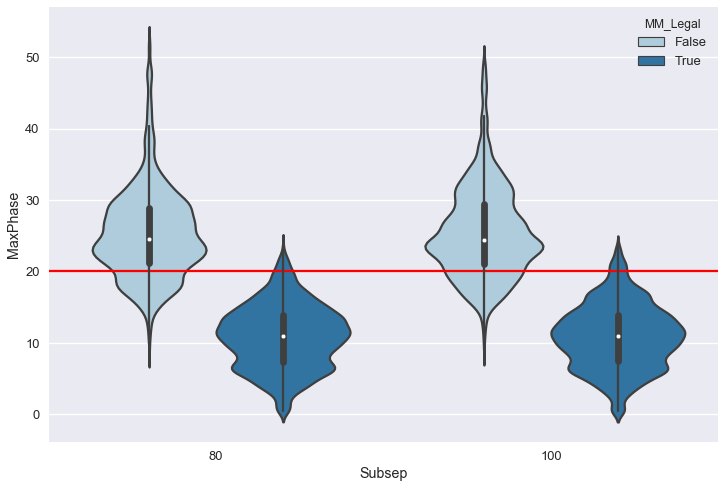

In [115]:
plt.figure(figsize=(12,8))
plt.axhline(20, color='red')
sns.violinplot(data=combined_data, x='Subsep', y='MaxPhase', hue='MM_Legal');

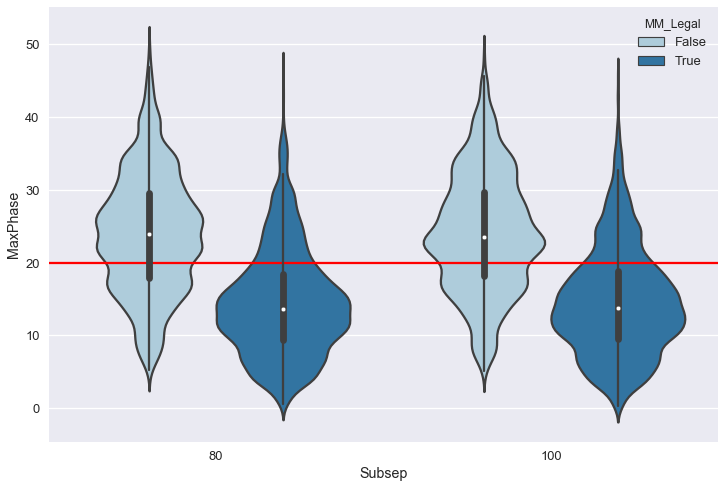

In [116]:
plt.figure(figsize=(12,8))
plt.axhline(20, color='red')
sns.violinplot(data=combined_data_after_subst, x='Subsep', y='MaxPhase', hue='MM_Legal');

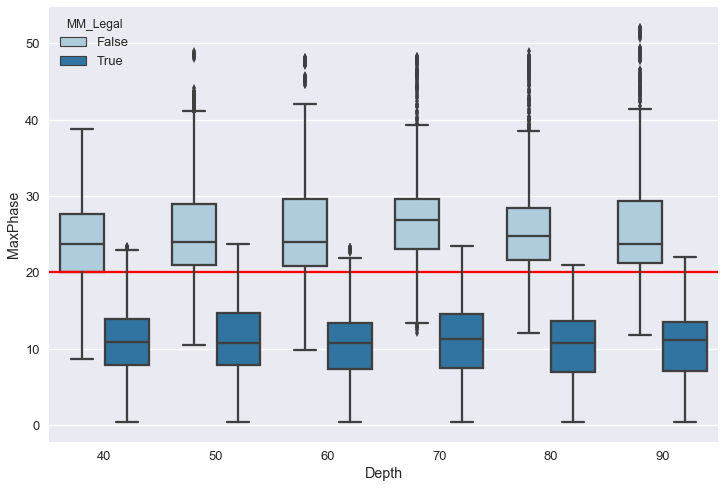

In [117]:
plt.figure(figsize=(12,8))
plt.axhline(20, color='red')
sns.boxplot(data=combined_data, x='Depth', y='MaxPhase', hue='MM_Legal');

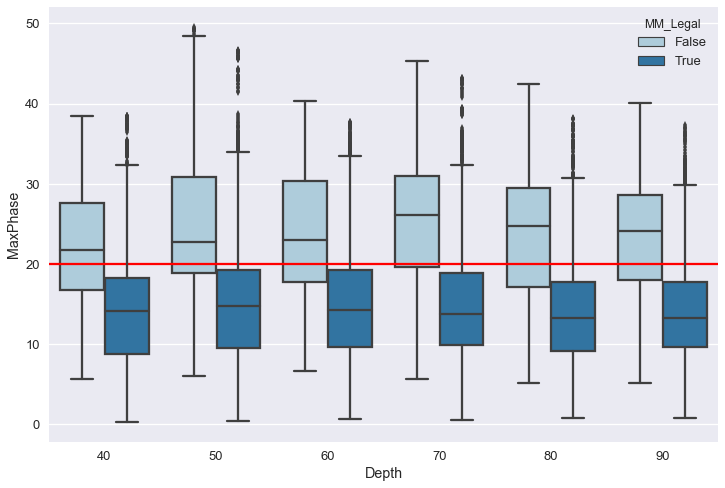

In [118]:
plt.figure(figsize=(12,8))
plt.axhline(20, color='red')
sns.boxplot(data=combined_data_after_subst, x='Depth', y='MaxPhase', hue='MM_Legal');

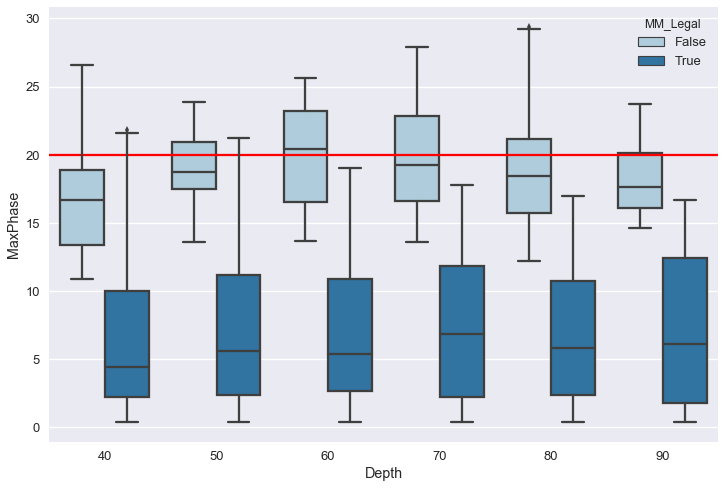

In [119]:
plt.figure(figsize=(12,8))
plt.axhline(20, color='red')
sns.boxplot(data=combined_data[combined_data['Scenario'] == 'Spare substitution'], x='Depth', y='MaxPhase', hue='MM_Legal');

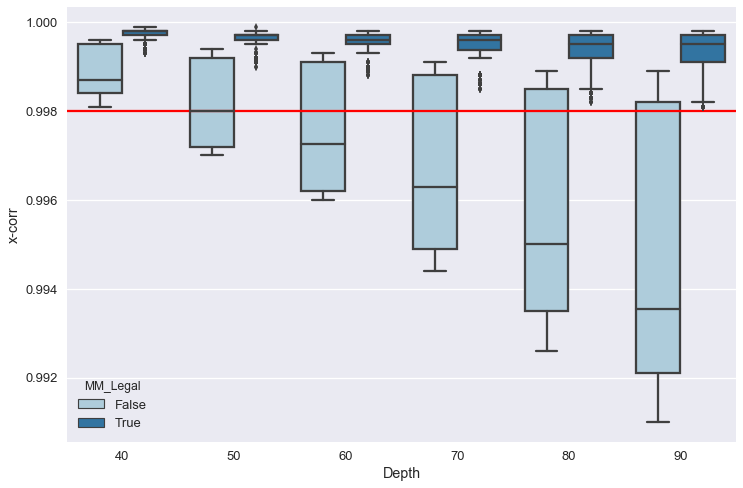

In [120]:
plt.figure(figsize=(12,8))
plt.axhline(0.998, color='red')
sns.boxplot(data=combined_data[combined_data['Scenario'] == 'One gun dropout'], x='Depth', y='x-corr', hue='MM_Legal');

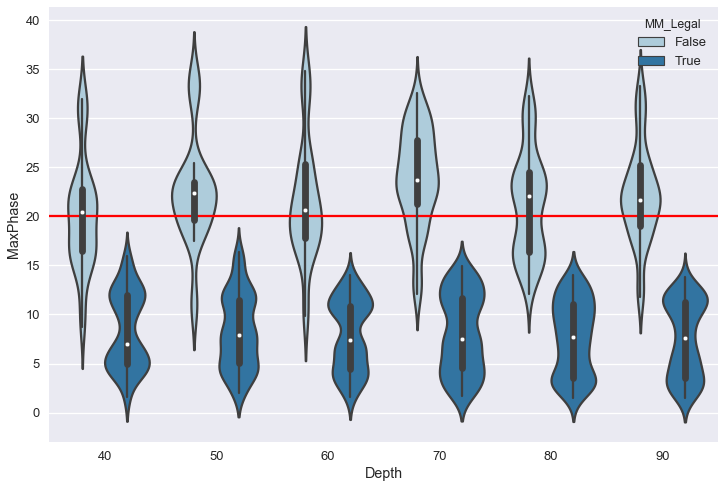

In [121]:
plt.figure(figsize=(12,8))
plt.axhline(20, color='red')
sns.violinplot(data=combined_data[combined_data['Scenario'] == 'One gun dropout'], x='Depth', y='MaxPhase', hue='MM_Legal');

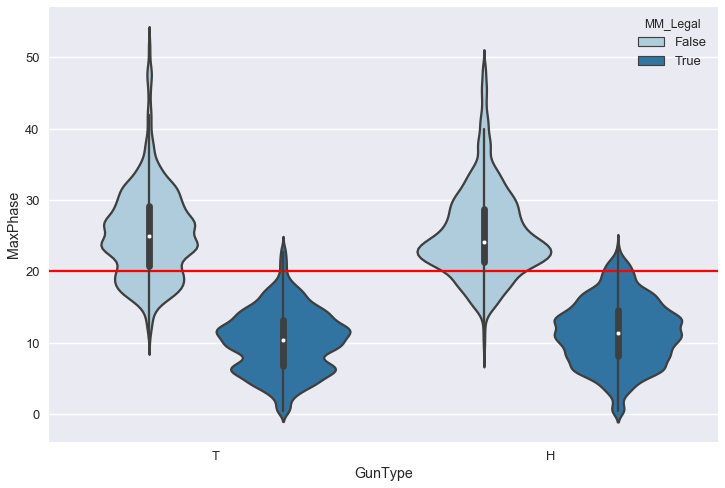

In [122]:
plt.figure(figsize=(12,8))
plt.axhline(20, color='red')
sns.violinplot(data=combined_data, x='GunType', y='MaxPhase', hue='MM_Legal');

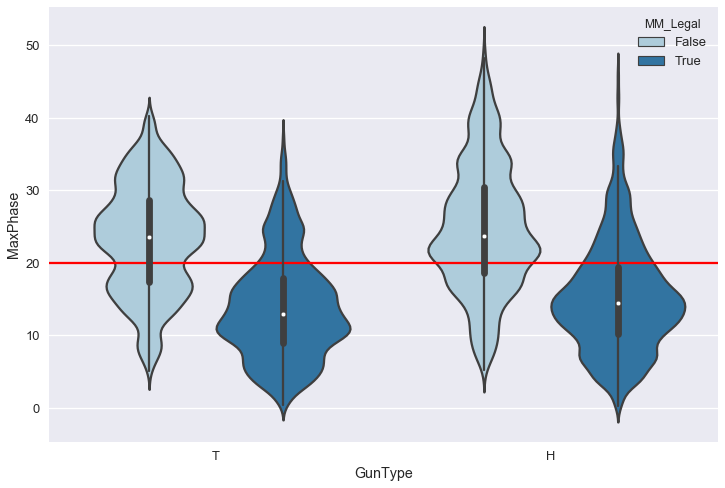

In [123]:
plt.figure(figsize=(12,8))
plt.axhline(20, color='red')
sns.violinplot(data=combined_data_after_subst, x='GunType', y='MaxPhase', hue='MM_Legal');

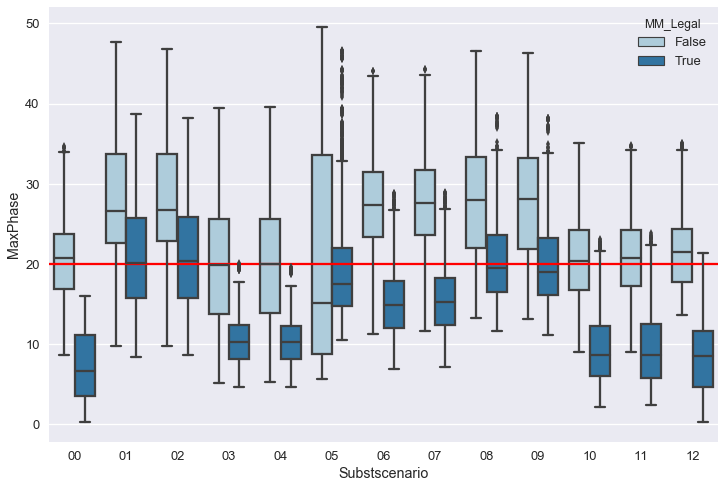

In [124]:
plt.figure(figsize=(12,8))
plt.axhline(20, color='red')
sns.boxplot(data=combined_data_after_subst, x='Substscenario', y='MaxPhase', hue='MM_Legal');

### Checking correlation between some statistical values
To answer questions like: If x-corr is bad, is always MaxPhase equally bad?
Does traditional broadband specs capture bad combinations also according to other specs?

Comment to above figure:
The red spec lines form a 4-field matrix.

Many combinations are bad using both specs (lower right field).

But many combinations that fullfill the x-corr spec, fail the MaxPhase spec (upper right field), also quite significantly (>30 degrees).

Also many combinations that meet the MaxPhase spec fails the x-corr spec (lower left field).

Note that dark dots are still legal combinations according to the MasterMatrix. Light dots are all combinations.

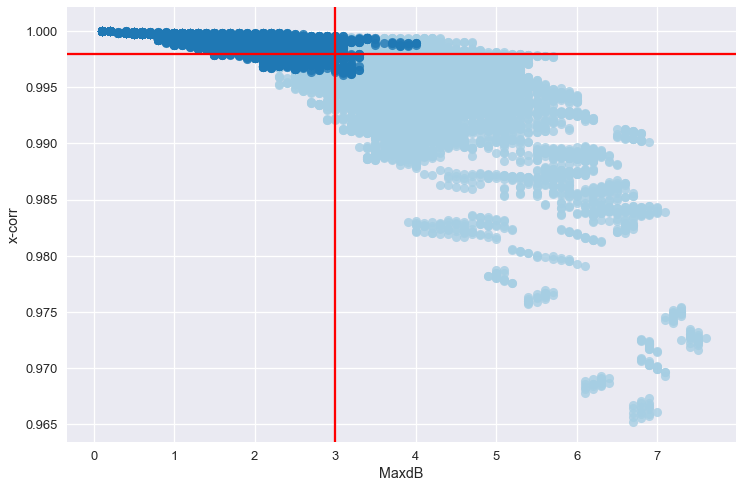

In [125]:
plt.figure(figsize=(12,8))
plt.axhline(0.998, color='red')
plt.axvline(3, color='red')
sns.regplot(x=combined_data["MaxdB"], y=combined_data["x-corr"], fit_reg=False)
sns.regplot(x=combined_data[(combined_data['MM_Legal'])]["MaxdB"], y=combined_data[(combined_data['MM_Legal'])]["x-corr"], fit_reg=False);

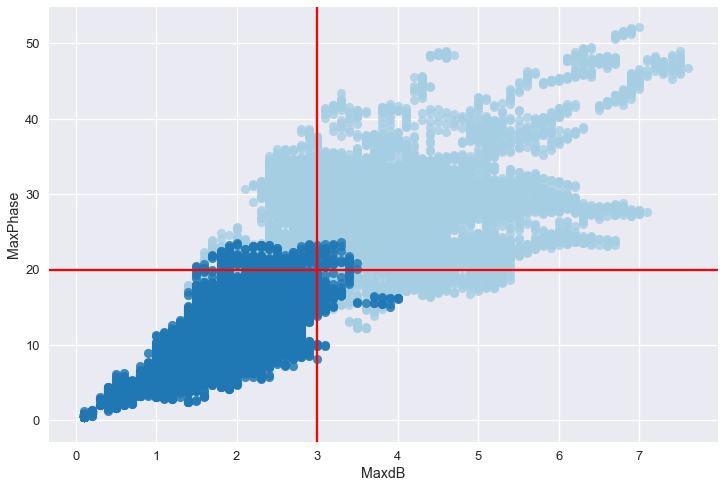

In [126]:
plt.figure(figsize=(12,8))
plt.axhline(20, color='red')
plt.axvline(3, color='red')
sns.regplot(x=combined_data["MaxdB"], y=combined_data["MaxPhase"], fit_reg=False)
sns.regplot(x=combined_data[(combined_data['MM_Legal'])]["MaxdB"], y=combined_data[(combined_data['MM_Legal'])]["MaxPhase"], fit_reg=False);

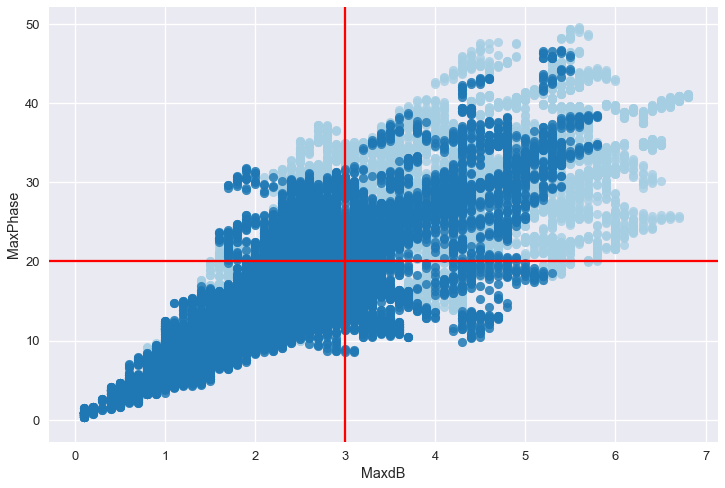

In [127]:
plt.figure(figsize=(12,8))
plt.axhline(20, color='red')
plt.axvline(3, color='red')
sns.regplot(x=combined_data_after_subst["MaxdB"], y=combined_data_after_subst["MaxPhase"], fit_reg=False)
sns.regplot(x=combined_data_after_subst[(combined_data_after_subst['MM_Legal'])]["MaxdB"], y=combined_data_after_subst[(combined_data_after_subst['MM_Legal'])]["MaxPhase"], fit_reg=False);

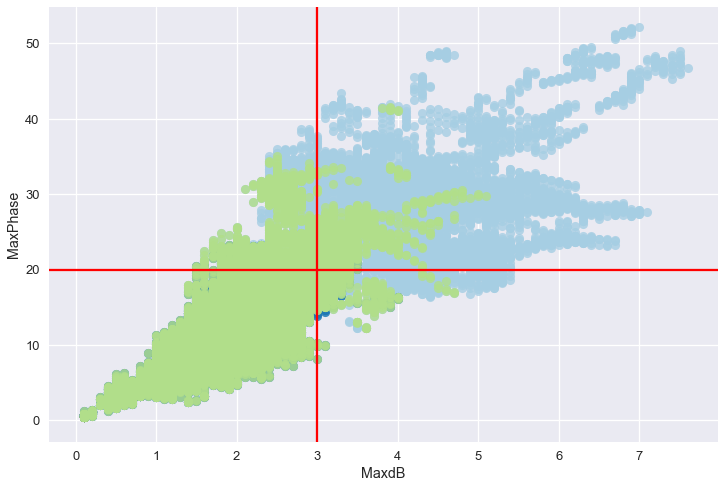

In [128]:
plt.figure(figsize=(12,8))
plt.axhline(20, color='red')
plt.axvline(3, color='red')
sns.regplot(x=combined_data["MaxdB"], y=combined_data["MaxPhase"], fit_reg=False)
sns.regplot(x=combined_data[(combined_data['MM_Legal'])]["MaxdB"], y=combined_data[(combined_data['MM_Legal'])]["MaxPhase"], fit_reg=False)
sns.regplot(x=combined_data[(combined_data['cc_Legal'])]["MaxdB"], y=combined_data[(combined_data['cc_Legal'])]["MaxPhase"], fit_reg=False);
#sns.regplot(x=combined_data[(combined_data['bb_Legal'])]["MaxdB"], y=combined_data[(combined_data['bb_Legal'])]["MaxPhase"], fit_reg=False);

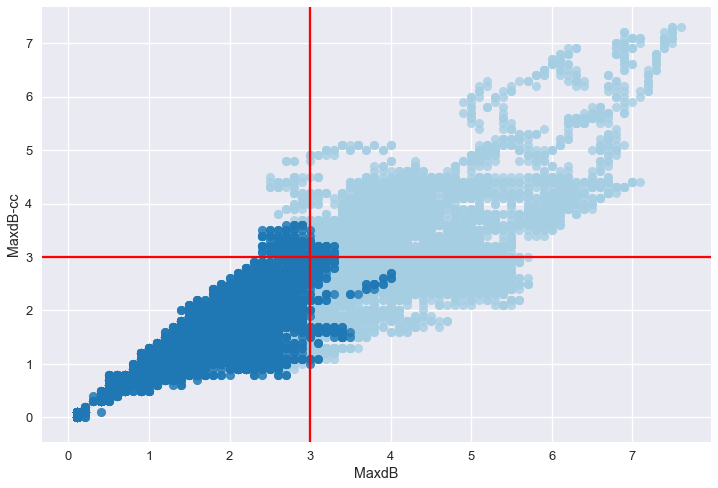

In [129]:
plt.figure(figsize=(12,8))
plt.axhline(3, color='red')
plt.axvline(3, color='red')
sns.regplot(x=combined_data["MaxdB"], y=abs(combined_data["MaxdB-cc"]), fit_reg=False)
sns.regplot(x=combined_data[(combined_data['MM_Legal'])]["MaxdB"], y=abs(combined_data[(combined_data['MM_Legal'])]["MaxdB-cc"]), fit_reg=False);

Note: abs(MaxdB-cc) correlates with MaxdB (check why this is different between bb and conventional stats)

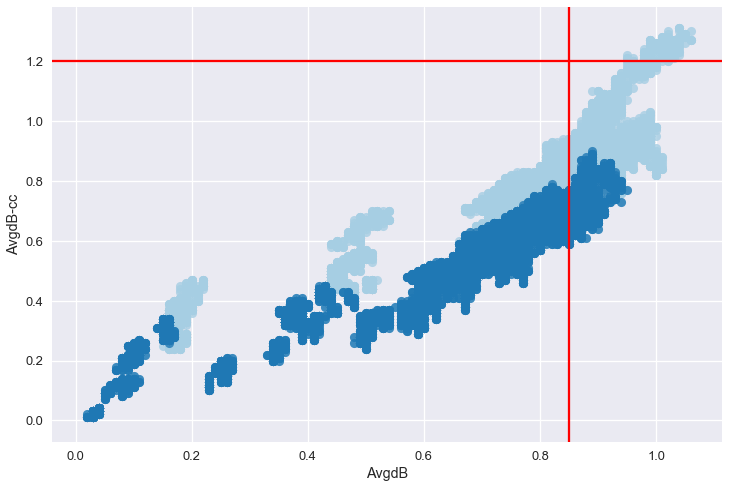

In [130]:
plt.figure(figsize=(12,8))
plt.axhline(1.2, color='red')
plt.axvline(0.85, color='red')
sns.regplot(x=combined_data["AvgdB"], y=combined_data["AvgdB-cc"], fit_reg=False)
sns.regplot(x=combined_data[(combined_data['MM_Legal'])]["AvgdB"], y=combined_data[(combined_data['MM_Legal'])]["AvgdB-cc"], fit_reg=False);

Not that this plot could be misleading wrt distribution (many dots on top of eachother), box plot shown previously mitigates this.

In [131]:
combined_data_after_subst.columns

Index(['index', 'AvgdB', 'MaxdB', 'MaxPhase', 'SourceVolume', 'GunType',
       'Depth', 'Subsep', 'Substscenario', 'Temperature', 'Peak', 'Peakch',
       'PtoB', 'PtoBch', 'x-corr', 'AvgdB-cc', 'MaxdB-cc', 'Bubble',
       'Scenario', 'bb_Legal', 'cc_Legal', 'MM_Legal'],
      dtype='object')

In [132]:
combined_data.columns

Index(['index', 'AvgdB', 'MaxdB', 'MaxPhase', 'SourceVolume', 'GunType',
       'Depth', 'Subsep', 'Temperature', 'Peak', 'Peakch', 'PtoB', 'PtoBch',
       'x-corr', 'AvgdB-cc', 'MaxdB-cc', 'Bubble', 'Scenario', 'bb_Legal',
       'cc_Legal', 'bb_eps_Legal', 'MM_Legal'],
      dtype='object')

In [133]:
combined_data_after_subst_clean = combined_data_after_subst.drop(columns=['Substscenario'])
combined_data_clean = combined_data.drop(columns=['bb_eps_Legal'])

In [134]:
combined_data_all = pd.concat([combined_data_clean, combined_data_after_subst_clean])

In [135]:
combined_data_all.columns

Index(['index', 'AvgdB', 'MaxdB', 'MaxPhase', 'SourceVolume', 'GunType',
       'Depth', 'Subsep', 'Temperature', 'Peak', 'Peakch', 'PtoB', 'PtoBch',
       'x-corr', 'AvgdB-cc', 'MaxdB-cc', 'Bubble', 'Scenario', 'bb_Legal',
       'cc_Legal', 'MM_Legal'],
      dtype='object')

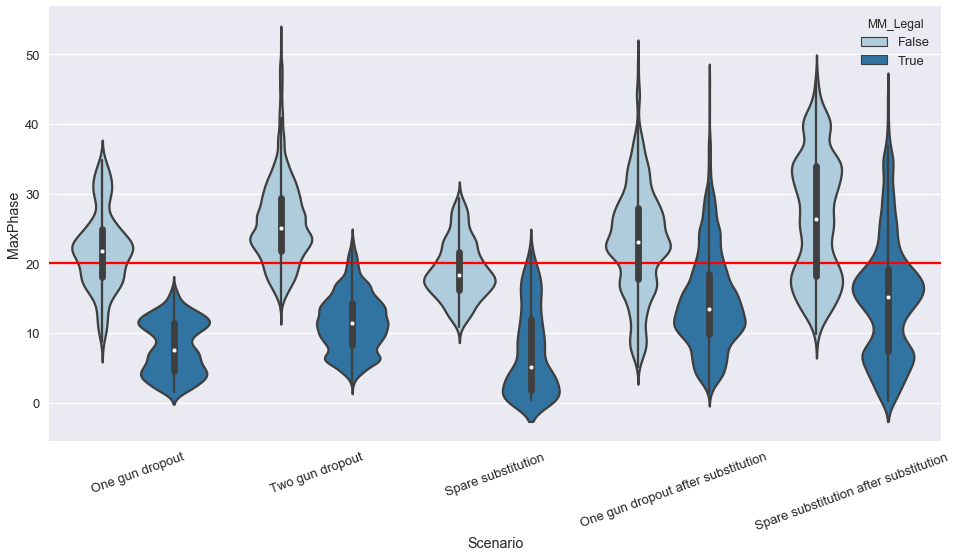

In [136]:
plt.figure(figsize=(16,8))
plt.axhline(20, color='red')
plt.xticks(rotation=20)
sns.violinplot(data=combined_data_all, x='Scenario', y='MaxPhase', hue='MM_Legal');

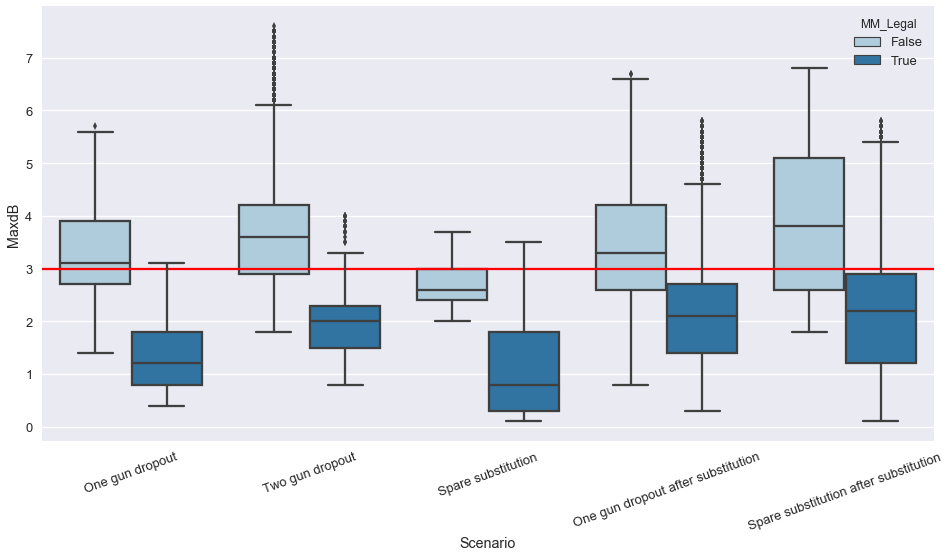

In [137]:
plt.figure(figsize=(16,8))
plt.axhline(3, color='red')
plt.xticks(rotation=20)
sns.boxplot(data=combined_data_all, x='Scenario', y='MaxdB', hue='MM_Legal');

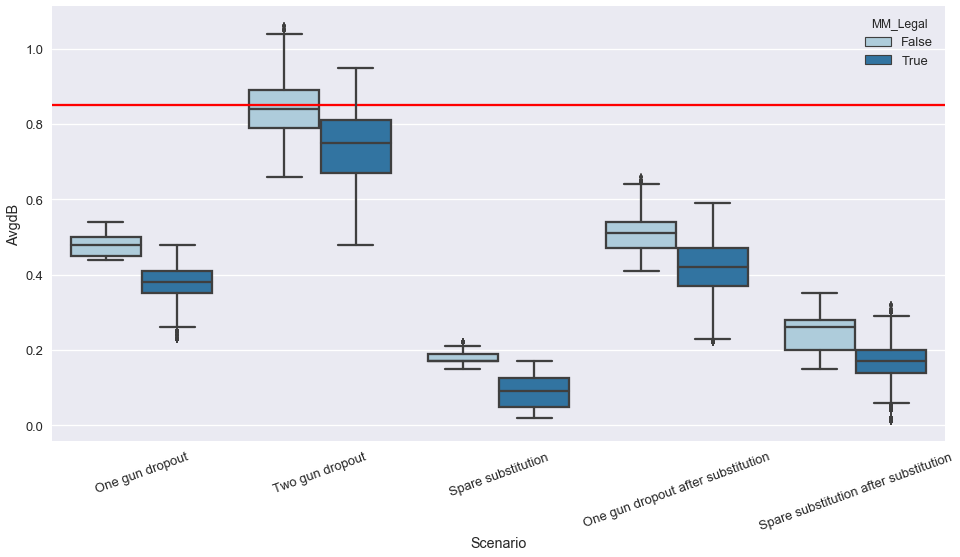

In [138]:
plt.figure(figsize=(16,8))
plt.axhline(0.85, color='red')
plt.xticks(rotation=20)
sns.boxplot(data=combined_data_all, x='Scenario', y='AvgdB', hue='MM_Legal');